# Analysis of NGC 3627 with Optical + X-ray wavelength data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations

from astropy.io import fits                     # for file handing 
from astropy.table import QTable                # for reading tables
from astropy.coordinates import SkyCoord, FK5   # for defining sky coordinates
import astropy.units as u                       # for using astronomical units (degs)
from astropy.wcs import WCS

from XRBID.AutoPhots import RunPhots, DaoFindObjects
from XRBID.WriteScript import (WriteReg, WriteScalings,
                               WriteDS9)
from XRBID.Sources import (LoadSources, GetCoords, GetIDs,
                           DaoClean, Crossref, GetDaoPhots)
from XRBID.DataFrameMod import (RemoveElse, FindUnique, BuildFrame,
                                Find)
from XRBID.Align import CorrectAstrometry, CalcPU
from XRBID.XRTools import FindSNRs, Lum
from XRBID.CMDs import (MakeCMD, MakeCCD, FitSED,
                        PlotSED)

from photometry_utils import instrument_info

from regions import CircleSkyRegion, Regions    # for defining sky regions
from regions import TextSkyRegion               # for defining text regions

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

## Notes
1. SN 2016cok is a cluster???

# Mosaicking
## Querying data with astroquery

In [7]:
filters = ["F275W", "F336W", "F438W", "F555W", "F814W"]
obs_id = [13364, 13477, 15654, 12968]

print("Finding observations for WFC3/UVIS images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="HST",
                                        filters=filters,
                                        proposal_id=obs_id, instrument_name="WFC3/UVIS")
print("Done")

Finding observations for WFC3/UVIS images...
Done


In [ ]:
obs_table

In [9]:
%%time
cd(hstdir)
print("Downloading data.\nThis may take several minutes... \n")
products = Observations.get_product_list(obs_table)
data_prod = ['FLC']       
data_type = ['HAP-SVM']   

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")


In [11]:
# Gathering the FLC file names
input_flcs = glob.glob(os.path.join('mastDownload','HST','*','*.fits'))

# Moving files from mastDownload directory into current directory
for flc in input_flcs:
  shutil.copy(flc, os.path.basename(flc))

shutil.rmtree('mastDownload') # removes the extra directories
print("Done")

Done


In [13]:
flc_files = glob.glob("hst*_acs_wfc_*_j*_flc.fits")
flc_files.sort()       # Alphabetizing files

for i,f in enumerate(flc_files):
    try: hdu = fits.open(f)
    except: print(f,"not good. Please remove.")

## F555W
The following code will be run in a python terminal

In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

flc_files = glob.glob("*f555w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f555w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False)  

## F814W

In [ ]:
flc_files = glob.glob("*f814w*flc*.fits")
flc_files.sorqqt()

adriz(flc_files, output='M66_mosaic_uvis_f814w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

## F438W

In [ ]:
flc_files = glob.glob("*f438w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f438w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

## F336W

In [ ]:
flc_files = glob.glob("*f336w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f336w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

## F275W

In [ ]:
flc_files = glob.glob("*f275w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f275w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

# Photometry

## F814W

In [ ]:
f814w_data = fits.getdata(f814w)
f814w_data_sliced = f814w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
f814w_objects = DaoFindObjects(f814w_data_sliced, fwhm=0.10*2, pixtoarcs=pixtoarcs, threshold=2, plot=True)

# investigating the daofind sources and extracting their photometry
f814w_hdu = fits.open(f814w)
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(f814w_hdu, gal="M66", instrument="WFC3",
                                               filter='F814W', fwhm_arcs=0.10*2, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f814w_hdu.close()

# ((np.float64(-0.8588325849729528),),
#  np.float64(0.1807607521654574),
#  np.float64(-0.3719457463759386),
#  np.float64(0.10642947110641915))

## F555W

In [ ]:
f555w_data = fits.getdata(f555w)
f555w_data_sliced = f555w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.18 * 2 # originally found 0.18 arcsec through ds9
f555w_objects = DaoFindObjects(f555w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True)

#investigating the daofind sources and extracting their photometry
f555w_hdu = fits.open(f555w)
apcorr555w, aperr555w, apcorr_ext555w, aperr_ext555w = RunPhots(f555w_hdu, gal="M66", instrument="WFC3",
                                               filter='F555W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f555w_hdu.close()

# ((np.float64(-0.8814290765714752),),
#  np.float64(0.24055442323969883),
#  np.float64(-0.3472747023393392),
#  np.float64(0.12601848622183956))

## F438W

In [ ]:
f438w_data = fits.getdata(f438w)
f438w_data_sliced = f438w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.11 * 2 # originally found 0.18 arcsec through ds9
f438w_objects = DaoFindObjects(f438w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.09)
print(len(f438w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f438w_hdu = fits.open(f438w)
apcorr438w, aperr438w, apcorr_ext438w, aperr_ext438w = RunPhots(f438w_hdu, gal="M66", instrument="WFC3",
                                               filter='F438W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f438w_hdu.close()

# ((np.float64(-0.9175731144364969),),
#  np.float64(0.2291917542835823),
#  np.float64(-0.4745254777532202),
#  np.float64(0.15543813531799572))

## F336W

In [ ]:
f336w_data = fits.getdata(f336w)
f336w_data_sliced = f336w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f336w_objects = DaoFindObjects(f336w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.05)
print(len(f336w_objects)) # found with 195 sources fwhm=0.10

# investigating the daofind sources and extracting their photometry
f336w_hdu = fits.open(f336w)
apcorr336w, aperr336w, apcorr_ext336w, aperr_ext336w = RunPhots(f336w_hdu, gal="M66", instrument="WFC3",
                                               filter='F336W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f336w_hdu.close()

# ((np.float64(-0.9540754478692428),),
#  np.float64(0.23448030394882666),
#  np.float64(-0.43512525755218445),
#  np.float64(0.13649683194194648))

## F275W

In [ ]:
f275w_data = fits.getdata(f275w)
f275w_data_sliced = f275w_data[4400:5000, 4300:4900]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f275w_objects = DaoFindObjects(f275w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.015)
print(len(f275w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f275w_hdu = fits.open(f275w)
apcorr275w, aperr275w, apcorr_ext275w, aperr_ext275w = RunPhots(f275w_hdu, gal="M66", instrument="WFC3",
                                               filter='F275W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f275w_hdu.close()

# ((np.float64(-0.9707309801124901),),
#  np.float64(0.25887846989477437),
#  np.float64(-0.4419304737417187),
#  np.float64(0.1511766174865048))

# Astrometric Corrections

In [ ]:
M66_CSC = LoadSources(chandra_hst_dir+"cscresults_M66_renamed.frame")
M66_unique = FindUnique(M66_CSC, header="CSC ID")
WriteReg(M66_unique, outfile=chandra_hst_dir+"M66_cscsources.reg", idheader="CSC ID", 
         radius=5, radunit="arcsec", width=2, color="hotpink")

In [ ]:
M66_calibrators = ["2CXO J112014.8+125814",
                   "2CXO J112018.9+130135",
                   "2CXO J112019.1+125947", # Not sure about this (upper left corner)
                   "2CXO J112019.5+125958", # Not sure about this (upper left corner)
                   "2CXO J112018.8+125924",
                  ] 
print(f"{len(M66_calibrators)} calibrators to match")

M66_calibrators = RemoveElse(M66_unique, keep=M66_calibrators, header='CSC ID')
print(f"{len(M66_calibrators)} calibrators found")

WriteReg(M66_calibrators, outfile=chandra_hst_dir+"M66_calibrators.reg")

In [ ]:
base_coords = GetCoords(hstdir+"M66_daofind_f555w_wfc3_fk5.reg")
cat_coords = [M66_calibrators["RA"].values.tolist(),
              M66_calibrators["Dec"].values.tolist()]

CorrectAstrometry(base_coords, cat_coords, returnshifts=True,
                 savebasereg=chandra_hst_dir+"M66_astrocorrect.reg")

# Input min and max separation: 0, 9.6e-5
# Min and max x residuals: -3e-5, 2.2e-5
# Min and max y residuals: -4.2e-5, 1.6e-5

# RESULTS OF ASTROMETRY CORRECTION

# Median offsets in x and y:
#  -2.018614964072185e-05 3.766607498967289e-05 degrees
#  -0.07267013870659866 0.13559786996282241 arcsecs

# Standard deviation in x and y offsets:
#  1.7643739978865733e-05 1.9961232387211725e-05 degrees
#  0.06351746392391663 0.07186043659396221 arcsecs

#  (np.float64(-2.018614964072185e-05),
#  np.float64(3.766607498967289e-05),
#  np.float64(1.7643739978865733e-05),
#  np.float64(1.9961232387211725e-05))

Assuming that the above astrometric corrections and its outputs are correct, since the standard deviations in the x and y offsets are bigger than their corresponding median offsets, there is not any correction needed between them. 

## Calculating Positional Uncertainties

In [2]:
M66_CSC = LoadSources(chandra_hst_dir+"cscresults_M66_renamed.frame")
display(M66_CSC)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/cscresults_M66_renamed.frame...


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,2.158629e-14,2.700286e-14,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,2.096613e-14,2.689218e-14,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,2.943952e-14,3.440386e-14,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,2.366824e-13,2.788378e-13,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,5.671396e-15,8.390559e-15,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,2.248525e-15,4.208778e-15,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.359917e-15,7.956849e-15,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,3.837669e-14,4.670929e-14,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,1.775502e-15,4.142838e-15,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118


In [3]:
sig1, sig2 = CalcPU(M66_CSC, std=[0.06352,0.07186], sig2search='Err Ellipse Major')

In [4]:
M66_CSC['1Sig'] = sig1  # Saves sig1 to a new header called '1Sig'
M66_CSC['2Sig'] = sig2  # Saves sig2 to a new header called '2Sig'

# The new DataFrame has 1 and 2sig added at the end of the columns list
display(M66_CSC)

M66_CSC.to_csv(chandra_hst_dir+'M66_csc_astrocorrected.frame')

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144


In [5]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_CSC, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_CSC, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M101_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandra_hst_dir+"M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144


In [ ]:
# Saving the positional uncertainties as region files
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), radunit='arcsec', \
         idheader="CSC ID", outfile=chandra_hst_dir+'M66_bestrads_2sig.reg')
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), radunit='arcsec', \
         outfile=chandra_hst_dir+'M66_bestrads_1sig.reg')g

# Identifying Optical Counterparts to X-ray sources

In [6]:
x,y = GetCoords(hstdir+"M66_daofind_f555w_wfc3_img.reg")
ids = GetIDs(hstdir+"M66_daofind_f555w_wfc3_img.reg")
ra,dec = GetCoords(hstdir+"M66_daofind_f555w_wfc3_fk5.reg")

# Compiling into a single DataFrame
DaoFrame = BuildFrame(headers=['DaoID','X','Y','RA','Dec'], 
                      values=[ids,x,y,ra,dec])
DaoFrame.to_csv(hstdir+"M66_daofind_acs_coords.frame")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daofind_f555w_wfc3_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daofind_f555w_wfc3_img.reg
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daofind_f555w_wfc3_fk5.reg


In [7]:
DaoFrame = pd.read_csv(hstdir+"M66_daofind_acs_coords.frame").drop("Unnamed: 0", axis=1)
display(DaoFrame)

,DaoID,X,Y,RA,Dec
0,1,4044.301157,506.383541,170.058899,12.933998
1,2,4071.287505,514.796584,170.058594,12.934091
2,3,4174.768903,607.892406,170.057425,12.935115
3,4,3852.428200,659.309812,170.061065,12.935681
4,5,3885.366892,660.899267,170.060693,12.935699
...,...,...,...,...,...
35153,35154,2559.137495,8946.778618,170.075675,13.026889
35154,35155,2270.289930,8989.284099,170.078938,13.027356
35155,35156,2218.000801,9011.531171,170.079529,13.027601
35156,35157,2269.749207,9011.687347,170.078944,13.027603


In [8]:
# Loading in the original DataFrame containing the best 2sig radii for each source
M66_best = LoadSources(chandra_hst_dir+"M66_csc_bestrads.frame")

# Reading in the newly-saved img region file
xsources, ysources = GetCoords(chandra_hst_dir+"M66_bestrads_2sig_img.reg")
# Adding the image coordinates to the DataFrame
M66_best["X"] = xsources
M66_best["Y"] = ysources

# Convert the radius from arcseconds to pixels. 
# The conversion is 0.05 for ACS/WFC and 0.03962 for WFC3/UVIS
M66_best["2Sig (pix)"] = M66_best["2Sig"] / 0.03962 

# Saving the changes to the DataFrame
M66_best.to_csv(chandra_hst_dir+"M66_csc_bestrads.frame")
display(M66_best)


Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_csc_bestrads.frame...
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_bestrads_2sig_img.reg


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.420311,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746,3732.25780,5731.0323,6.025886
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,0.412041,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443,3692.38100,5715.9783,6.270647
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.488407,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415,3747.18600,5834.4389,5.941826
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755,3622.72450,5794.0764,87.121537
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.477466,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133,3582.56790,5797.8225,8.711076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,3.984317,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654,-2024.96930,6837.4179,27.048301
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.338261,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475,6124.79330,11221.0620,25.807047
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,4.414767,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728,2023.27800,11553.1970,10.215239
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,3.872333,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144,-1021.79190,1688.5554,26.934484


In [ ]:
DaoCleanFrame = DaoClean(daosources=DaoFrame, sources=M66_best, sourceid="CSC ID", 
                         coordsys="img", coordheads=['X','Y'], radheader="2Sig (pix)",
                         wiggle=0.5) 


# Renaming the DaoID header to "F555W ID", to match the output of the other filters
DaoCleanFrame = DaoCleanFrame.rename(columns={'DaoID': 'F555W ID'})

display(DaoCleanFrame)

WriteReg(DaoCleanFrame, coordsys='fk5', width=2, radius=0.2, radunit='arcsec',
         outfile=chandra_hst_dir+'M66_daoclean_f555w_wfc3_fk5.reg')

Cleaning DAOFind sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,F555W ID,X,Y,RA,Dec,CSC ID
0,18393,3728.392237,5731.691614,170.062466,12.991505,2CXO J112014.9+125929
1,18431,3730.3829,5734.693669,170.062444,12.991539,2CXO J112014.9+125929
2,18254,3690.922608,5713.903685,170.06289,12.99131,2CXO J112015.0+125928
3,18303,3693.339708,5721.089782,170.062862,12.991389,2CXO J112015.0+125928
4,19206,3746.7145,5828.6536,170.06226,12.992573,2CXO J112014.9+125933
...,...,...,...,...,...,...
236,3994,4869.455824,3777.647306,170.049579,12.97,2CXO J112011.8+125811
237,34886,3768.771693,8363.063045,170.062011,13.020465,2CXO J112014.9+130113
238,1804,4463.71084,2888.783967,170.054162,12.960218,2CXO J112013.0+125736
239,1476,3375.849092,2661.999469,170.066447,12.957722,2CXO J112015.9+125727


## Cross-referencing sources across filters

In [10]:
cd(hstdir)
regions = ["M66_daofind_f275w_wfc3_img.reg",
           "M66_daofind_f336w_wfc3_img.reg",
           "M66_daofind_f438w_wfc3_img.reg",
           "M66_daofind_f814w_wfc3_img.reg"]

DaoCleanMatch = Crossref(DaoCleanFrame, regions=regions, catalogs=['F275W', 'F336W', 'F438W', 'F814W'],
                        coordheads=['X','Y'], sourceid="F555W ID",
                        outfile="M66_daoclean_matches.frame")

DaoCleanMatch

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID
0,3728.392237,5731.691614,18393,NaN,95500,34799,17413,170.062466,12.991505,2CXO J112014.9+125929
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413,170.062444,12.991539,2CXO J112014.9+125929
2,3690.922608,5713.903685,18254,NaN,95118,34583,NaN,170.062890,12.991310,2CXO J112015.0+125928
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928
4,3746.714500,5828.653600,19206,NaN,NaN,35989,NaN,170.062260,12.992573,2CXO J112014.9+125933
...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812,157738,59483,NaN,170.062011,13.020465,2CXO J112014.9+130113
258,4463.710840,2888.783967,1804,48203,NaN,NaN,1718,170.054162,12.960218,2CXO J112013.0+125736
259,3375.849092,2661.999469,1476,NaN,25603,5443,1413,170.066447,12.957722,2CXO J112015.9+125727
260,3375.849092,2661.999469,1476,NaN,25753,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727


In [11]:
# Adding "CSC ID" to columns in DaoCleanMatch
DaoCleanMatch["CSC ID"] = None

# Adding the CSC IDs of each source the daosources are associated with
for i in range(len(DaoCleanMatch)): 
    # Searches for the CSC ID associated with each F555W ID (DaoID in DaoCleanFrame)
    tempid = DaoCleanMatch["F555W ID"][i] 
    tempcsc = Find(DaoCleanFrame, "F555W ID = " + str(tempid))["CSC ID"][0]
    DaoCleanMatch["CSC ID"][i] = tempcsc
    
# Updating the DataFrame
DaoCleanMatch.to_csv(hstdir+"M66_daoclean_matches.frame")
display(DaoCleanMatch)

,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID
0,3728.392237,5731.691614,18393,NaN,95500,34799,17413,170.062466,12.991505,2CXO J112014.9+125929
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413,170.062444,12.991539,2CXO J112014.9+125929
2,3690.922608,5713.903685,18254,NaN,95118,34583,NaN,170.062890,12.991310,2CXO J112015.0+125928
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928
4,3746.714500,5828.653600,19206,NaN,NaN,35989,NaN,170.062260,12.992573,2CXO J112014.9+125933
...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812,157738,59483,NaN,170.062011,13.020465,2CXO J112014.9+130113
258,4463.710840,2888.783967,1804,48203,NaN,NaN,1718,170.054162,12.960218,2CXO J112013.0+125736
259,3375.849092,2661.999469,1476,NaN,25603,5443,1413,170.066447,12.957722,2CXO J112015.9+125727
260,3375.849092,2661.999469,1476,NaN,25753,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727


In [12]:
# For each X-ray source, number the associated stars starting from 1.
tempcsc = DaoCleanMatch["CSC ID"][0] # Keeping track of the current X-ray source
DaoCleanMatch["StarID"] = None # Storing the star number for each X-ray source

starno = 1 # Star number counter

for i in range(len(DaoCleanMatch)): 
    # If this is a new CSC ID, save it to tempcsc and restart starno counter
    if tempcsc != DaoCleanMatch["CSC ID"][i]: 
        tempcsc = DaoCleanMatch["CSC ID"][i]
        starno = 1
    DaoCleanMatch["StarID"][i] = starno
    starno += 1 # adds one to the starno counter

# Saving the candidate region file with new numberings
WriteReg(DaoCleanMatch, coordsys="image", coordheads=["X","Y"], 
         idheader="StarID", width=2, fontsize=12,
         outfile=chandra_hst_dir+"M66_XRB_candidates.reg",
         radius=0.1, radunit='arcsec')

# DaoCleanMatch has now renumbered each star associated with 
# an X-ray source for simplicity
DaoCleanMatch.to_csv(hstdir+"M66_daoclean_matches.frame")
display(DaoCleanMatch)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_XRB_candidates.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_XRB_candidates.reg saved!


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,StarID
0,3728.392237,5731.691614,18393,NaN,95500,34799,17413,170.062466,12.991505,2CXO J112014.9+125929,1
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413,170.062444,12.991539,2CXO J112014.9+125929,2
2,3690.922608,5713.903685,18254,NaN,95118,34583,NaN,170.062890,12.991310,2CXO J112015.0+125928,1
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928,2
4,3746.714500,5828.653600,19206,NaN,NaN,35989,NaN,170.062260,12.992573,2CXO J112014.9+125933,1
...,...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812,157738,59483,NaN,170.062011,13.020465,2CXO J112014.9+130113,1
258,4463.710840,2888.783967,1804,48203,NaN,NaN,1718,170.054162,12.960218,2CXO J112013.0+125736,1
259,3375.849092,2661.999469,1476,NaN,25603,5443,1413,170.066447,12.957722,2CXO J112015.9+125727,1
260,3375.849092,2661.999469,1476,NaN,25753,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727,2


## Incorporating Other Catalogs

### Cluster Catalog
The cluster catalog being used below can be found from the PHANGS-CAT website, [here](https://archive.stsci.edu/hlsp/phangs/phangs-cat). Note that the catalog above was observed through wfc3. There's another one available taken through acs, [here](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table). However, since I am using the wfc3 instrument for all my analysis here, I am using the wfc3 catalog only.

In [16]:
# Read a BinTableHDU
cluster_hdu = fits.open('/Users/undergradstudent/Downloads/ngc3627/cluster/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_cluster-human-class12.fits')
clustertbl = QTable(cluster_hdu[1].data)
clustertbl

INDEX,ID_PHANGS_CLUSTERS,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA_TOT,PHANGS_F275W_VEGA_TOT_ERR,PHANGS_F336W_VEGA_TOT,PHANGS_F336W_VEGA_TOT_ERR,PHANGS_F438W_VEGA_TOT,PHANGS_F438W_VEGA_TOT_ERR,PHANGS_F555W_VEGA_TOT,PHANGS_F555W_VEGA_TOT_ERR,PHANGS_F814W_VEGA_TOT,PHANGS_F814W_VEGA_TOT_ERR,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,PHANGS_CI,PHANGS_AGE_MINCHISQ,PHANGS_AGE_MINCHISQ_ERR,PHANGS_MASS_MINCHISQ,PHANGS_MASS_MINCHISQ_ERR,PHANGS_EBV_MINCHISQ,PHANGS_EBV_MINCHISQ_ERR,PHANGS_REDUCED_MINCHISQ,NO_DETECTION_FLAG
int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,14,6614.89,3239.51,170.06613550163783,12.939565672437887,1.0,2,0.9,20.64478245728906,0.02659657396351643,20.93979017654412,0.030188736564226437,22.250655300429276,0.031346415447021464,22.27859441730564,0.016875740045112282,22.11064764254441,0.03901893634778962,0.004894710575974825,0.00012002236400823634,0.005149012301279204,0.00014331060515183322,0.0051853476618246,0.00014985637672020489,0.004488303673158532,6.983200680382467e-05,0.003450014679669524,0.00012410973040724197,1.4406957552854887,1.0,1.0,8719.629993702069,2694.2879321260407,0.31,0.03999999999999998,0.15571900335067532,0.0
2,46,7284.4,3396.34,170.05857517129016,12.94129168906165,1.0,1,0.8,24.105332415990546,0.37037020453020186,22.714208348075548,0.08964678639377795,22.519651769070073,0.027672450452808608,21.668955157650842,0.009359068435449567,20.217371142107172,0.008528855229104975,0.0002020724158307192,6.900054767200979e-05,0.0010045155423948492,8.302346398363295e-05,0.004047429496485954,0.00010326101122819036,0.007869333245767959,6.790160231908834e-05,0.01973020252367809,0.00015514284407774865,1.6525453388887816,2440.0,1412.0,435789.158149563,132243.1815034949,0.15,0.17,0.6757897715262302,0.0
3,55,6620.99,3457.63,170.0660666598804,12.941966204158541,1.0,1,1.0,22.281918510623996,0.07737770478364059,22.22169363119243,0.0616848745282317,22.46988424208646,0.027246659028787583,22.442268805930635,0.014600834523023043,21.98812430101322,0.02959330849684471,0.001083608980805747,7.730327650696346e-05,0.0015811116822482226,8.991884008849886e-05,0.0042372716090699316,0.00010644101884595906,0.003860223743174932,5.196364647241765e-05,0.003862160160097809,0.00010537395092536263,1.5549336132831346,182.0,28.0,17467.385090088555,2360.828541606472,0.0,0.01,0.7982185920792995,0.0
4,68,6698.34,3482.21,170.06519319571672,12.942236733359024,1.0,1,1.0,20.82626233865763,0.02611063539413167,20.81526062516283,0.022289843866434313,21.009603537555332,0.010733207751301713,20.91452051154636,0.006500915802188716,20.38050871921674,0.009989056907406837,0.004141284477435931,9.969238081274846e-05,0.005774784072017913,0.00011867308687031326,0.01626292222205026,0.00016093021202070686,0.015765646894598556,9.449216496329995e-05,0.01697760840966834,0.00015635452786221064,1.7234222094582332,210.0,0.0,80145.11041876292,9281.609214165932,0.01,0.03,0.181573970260038,0.0
5,90,6745.89,3520.91,170.06465624597297,12.942662654573844,1.0,1,1.0,22.925218259744764,0.13452151333237802,22.27913233033862,0.06630949310249956,22.105464738627294,0.022063156905752657,21.881795724754113,0.012211765860952238,21.189383833152473,0.016662480049139786,0.0005991736362875742,7.431113649301165e-05,0.0014996401795385338,9.167950055632037e-05,0.005927261726618868,0.00012056776794817406,0.006468472112226721,7.282653409476053e-05,0.008059840858327328,0.00012381565857698675,1.8696595576630655,500.0,151.0,55569.664341832664,1130.107884178833,0.0,0.1,

In [ ]:
regions = []
radius = 0.00005 * u.deg       # change this depending on the desired size of the radius
for i in range(len(clustertbl)):
    # create sky coordinates
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustertbl['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    sky_reg = CircleSkyRegion(center=center_sky, radius=radius)
    regions.append(sky_reg)

regs = Regions(regions)
regs.write(chandra_hst_dir+"cluster_catalog_.reg", format='ds9')
regs

In [ ]:
# Add a few degrees to the center coordinate of the source
# so that the region that is created would be above the source
clustercopy = clustertbl.copy()
clustercopy['PHANGS_DEC'] = clustercopy['PHANGS_DEC'] + 0.00005

text_regions = []
radius = 0.00008 * u.deg
for i in range(len(clustertbl)):
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustercopy['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    text_sky_reg = TextSkyRegion(center=center_sky, text=clustertbl['ID_PHANGS_CLUSTERS'][i])
    text_regions.append(sky_reg)

text_regs = Regions(text_regions)
# regs_text.write(chandra_hst_dir+"cluster_catalog_text.reg", format='ds9')
text_regs


In [17]:
# cluster coordinates in fk5 system
clusters_sky = SkyCoord(ra=clustertbl['PHANGS_RA'], dec=clustertbl['PHANGS_DEC'],
                          unit='deg', frame='icrs').transform_to(FK5)
clustertbl.add_column(col=clusters_sky.ra.deg, index=2,
                        name='RA')
clustertbl.add_column(col=clusters_sky.dec.deg, index=3,
                        name='Dec')                       
clustertbl.write(chandra_hst_dir+'cluster_catalog.txt', format='csv', overwrite=True)
# We are mainly only interested in the RA_fk5 and Dec_fk5  

In [47]:
# save an fk5 region file of the cluster catalog with WriteReg
clusterdf = clustertbl.to_pandas()
WriteReg(sources=clusterdf, outfile=chandra_hst_dir+'M66_cluster_catalog_fk5.reg',
         coordsys='fk5', coordheads=['RA', 'Dec'], idheader='ID_PHANGS_CLUSTERS',
         radius=0.2, radunit='arcsec')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_fk5.reg saved!


In [71]:
# save both the image and fk5 coordinates in the df
clusters_sky = SkyCoord(ra=clustertbl['PHANGS_RA'], dec=clustertbl['PHANGS_DEC'],
                          unit='deg', frame='icrs').transform_to(FK5)
with fits.open(f555w) as hdu:
    wcs = WCS(hdu['PRIMARY'].header)  
    print(wcs)              
clusters_pix = clusters_sky.to_pixel(wcs, origin=1)

clusters_pix


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 170.06006411545647 12.978893560524552 
CRPIX : 3941.092599017002 4585.730459454908 
CD1_1 CD1_2  : -1.1005555796954e-05 2.15389758956903e-22 
CD2_1 CD2_2  : 2.64730184271065e-22 1.10055557969543e-05 
NAXIS : 7880  9170


(array([3403.43545948, 4072.9464916 , 3409.53693632, 3486.88709962,
        3534.43735975, 3482.41771575, 3670.62826688, 3765.68865683,
        4144.73887549, 3871.59894932, 3744.9394757 , 4078.49957858,
        3844.30993084, 3947.85999319, 3915.68012718, 3452.55019316,
        3632.8202174 , 3832.68041004, 3974.02054232, 4029.54060407,
        4010.92079712, 3955.72089524, 3914.60106149, 3908.08117647,
        4119.22120506, 2891.73141101, 4016.81158147, 3152.34173038,
        4013.75184559, 3621.58189615, 4040.18213097, 3875.50254708,
        2628.95360882, 3978.72404699, 3943.22419935, 4000.60513671,
        3564.86517161, 2619.01521977, 3615.56522487, 4310.41522627,
        2684.60534097, 2707.13541229, 2773.7154529 , 4228.89549177,
        2893.69554623, 4162.43573683, 4143.56580487, 4138.17618778,
        3270.78623981, 4144.05636009, 2987.45652241, 2160.12673496,
        4179.21679787, 3358.98697777, 2489.05711158, 3349.04711058,
        4166.20714313, 2738.81747671, 1951.17750

In [ ]:
clusterdf.insert(4, column='X', value=clusters_pix[0])
clusterdf.insert(5, column='Y', value=clusters_pix[1])
clusterdf.to_csv(chandra_hst_dir+'M66_cluster_catalog.frame')

In [89]:
# Save an img region file 
WriteReg(clusterdf, idheader='ID_PHANGS_CLUSTERS', coordheads=['X', 'Y'],
         coordsys='image', outfile=chandra_hst_dir+'M66_cluster_catalog_img.reg',
         radius=0.0001, radunit='deg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_img.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_img.reg saved!


#### Investigating the ACS cluster catalog 

This catalog can be found [here](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table).

In [113]:
cluster_dir = '/Users/undergradstudent/Downloads/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-cluster-class12.fits'

with fits.open(cluster_dir) as cluster_hdu:
    clustertbl = QTable(cluster_hdu[1].data)

# convert cluster coordinates from icrs to fk5 system
clusters_sky = SkyCoord(ra=clustertbl['PHANGS_RA'], dec=clustertbl['PHANGS_DEC'],
                          unit='deg', frame='icrs').transform_to(FK5)
clustertbl.add_column(col=clusters_sky.ra.deg, index=4,
                        name='RA')
clustertbl.add_column(col=clusters_sky.dec.deg, index=5,
                        name='Dec')                       

clusterdf = clustertbl.to_pandas()
clusterdf.to_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_uvis_fk5.frame')

WriteReg(sources=clusterdf, outfile=chandra_hst_dir+'M66_cluster_catalog_acs-uvis_fk5.reg',
         coordsys='fk5', coordheads=['RA', 'Dec'], idheader='ID_PHANGS_CLUSTER',
         radius=0.3, radunit='arcsec')


# Manually creating a region file with image coordinates with this region file. 

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_acs-uvis_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cluster_catalog_acs-uvis_fk5.reg saved!


After comparing the regions files of clusters obtained from both acs and wfc3 instruments, I noticed that both their positions are the same except for their ids. Everything else is the same. 

### Supernova Remnants (SNRs)

I created this catalog myself by finding the catalogued SNRs

In [2]:
snr_catalog = pd.read_csv(chandra_hst_dir+"M66_snr_catalog.frame")

In [3]:
snr_catalog

,Unnamed: 0,SNR ID,RA,Dec
0,0,SN 1973R,170.048450,12.998440
1,1,SN 1989B,170.057960,13.005330
2,2,SN 1997bs,170.059375,12.972111
3,3,SN 2009hd,170.070670,12.979610
4,4,SN 2016cok,170.079292,12.982389


In [9]:
snr_catalog['RA'][3], snr_catalog['Dec'][3]

(np.float64(170.07067), np.float64(12.97961))

In [13]:
WriteReg(snr_catalog, idheader='SNR ID', coordsys='fk5',
        coordheads=['RA', 'Dec'], outfile=chandra_hst_dir+'M66_snr_catalog_fk5.reg',
        radius=0.25, radunit='arcsec')

# Creating an img region file using ds9

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_snr_catalog_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_snr_catalog_fk5.reg saved!


### Compact Association Clusters

The compact association catalog being used below can be found from the PHANGS-CAT website, [here](https://archive.stsci.edu/hlsp/phangs/phangs-cat). They have the catalogs available using the 3 different watershed algorithms for 16pc, 32pc and 64pc. The 16pc method has the most amount of sources, which is why I will be using my analysis.

In [ ]:
ws16pc = '/Users/undergradstudent/Downloads/ngc3627/assoc/vselect/ws16pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws16pc-main.fits'
ws32pc = '/Users/undergradstudent/Downloads/ngc3627/assoc/vselect/ws32pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws32pc-main.fits'
ws64pc = '/Users/åundergradstudent/Downloads/ngc3627/assoc/vselect/ws64pc/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_assoc-vselect-ws64pc-main.fits'

In [ ]:
with fits.open(ws16pc) as hdu1:
    assoc1 = QTable(hdu1[1].data)

# convert coordinates from icrs to fk5 system
assoc_sky = SkyCoord(ra=assoc1['reg_ra'], dec=assoc1['reg_dec'],
                          unit='deg', frame='icrs').transform_to(FK5)
assoc1.add_column(col=assoc_sky.ra.deg, index=3,
                        name='RA')
assoc1.add_column(col=assoc_sky.dec.deg, index=4,
                        name='Dec')                       
                        
# Convert to a df to use WriteReg to create region files
assoc1df = assoc1.to_pandas()
assoc1df.to_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws16pc.frame')

WriteReg(sources=assoc1df, outfile=chandra_hst_dir+'M66_assoc1_catalog_ws16pc_fk5.reg',
         coordsys='fk5', coordheads=['reg_ra', 'reg_dec'], idheader='reg_id',
         radius=0.3, radunit='arcsec')

# Manually creating a region file with image coordinates of this region file


Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg saved!


In [ ]:
with fits.open(ws32pc) as hdu2:
    assoc2 = QTable(hdu2[1].data)

# convert coordinates from icrs to fk5 system
assoc_sky = SkyCoord(ra=assoc2['reg_ra'], dec=assoc2['reg_dec'],
                          unit='deg', frame='icrs').transform_to(FK5)
assoc2.add_column(col=assoc_sky.ra.deg, index=3,
                        name='RA')
assoc2.add_column(col=assoc_sky.dec.deg, index=4,
                        name='Dec')   

# Convert to a df to use WriteReg to create region files
assoc2df = assoc2.to_pandas()
assoc2df.to_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws32pc.frame')

WriteReg(sources=assoc2df, outfile=chandra_hst_dir+'M66_assoc2_catalog_ws32pc_fk5.reg',
         coordsys='fk5', coordheads=['reg_ra', 'reg_dec'], idheader='reg_id',
         radius=0.3, radunit='arcsec')


Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc2_catalog_ws32pc_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc2_catalog_ws32pc_fk5.reg saved!


In [ ]:
with fits.open(ws64pc) as hdu3:
    assoc3 = QTable(hdu3[1].data)

# convert coordinates from icrs to fk5 system
assoc_sky = SkyCoord(ra=assoc3['reg_ra'], dec=assoc3['reg_dec'],
                          unit='deg', frame='icrs').transform_to(FK5)
assoc3.add_column(col=assoc_sky.ra.deg, index=3,
                        name='RA')
assoc3.add_column(col=assoc_sky.dec.deg, index=4,
                        name='Dec')   

# Convert to a df to use WriteReg to create region files
assoc3df = assoc3.to_pandas()
assoc3df.to_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws64pc.frame')

WriteReg(sources=assoc3df, outfile=chandra_hst_dir+'M66_assoc3_catalog_ws64pc_fk5.reg',
         coordsys='fk5', coordheads=['reg_ra', 'reg_dec'], idheader='reg_id',
         radius=0.3, radunit='arcsec')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc3_catalog_ws64pc_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc3_catalog_ws64pc_fk5.reg saved!


#### Investigating the compact associations catalog available [here](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table)

In [ ]:
assoc_dir = '/Users/undergradstudent/Downloads/catalogs/hlsp_phangs-cat_hst_uvis_ngc3627_multi_v1_obs-human-compact-association-class3.fits'

with fits.open(assoc_dir) as hdu4:
    assoc4 = QTable(hdu4[1].data)

# convert coordinates from icrs to fk5 system
assoc_sky = SkyCoord(ra=assoc4['PHANGS_RA'], dec=assoc4['PHANGS_DEC'],
                          unit='deg', frame='icrs').transform_to(FK5)
assoc4.add_column(col=assoc_sky.ra.deg, index=4,
                        name='RA')
assoc4.add_column(col=assoc_sky.dec.deg, index=5,
                        name='Dec')   

# Convert to a df to use WriteReg to create region files
assoc4df = assoc4.to_pandas()
assoc4df.to_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis.frame')

WriteReg(sources=assoc4df, outfile=chandra_hst_dir+'M66_assoc_catalog_acs-uvis_fk5.reg',
         coordsys='fk5', coordheads=['RA', 'Dec'], idheader='ID_PHANGS_CLUSTER',
         radius=0.3, radunit='arcsec')

# Manually creating a region file with image coordianates with this

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis_fk5.reg saved!


Interestingly, there are new sources in this catalog that are not in the other catalogs. Need to show these to Qiana

## Crossreferencing

In [175]:
cd(chandra_hst_dir)
DaoCleanMatch = LoadSources(hstdir+'M66_daoclean_matches.frame')
regions = ['M66_cluster_catalog_img.reg', 'M66_snr_catalog_img.reg']
catalog = Crossref(DaoCleanMatch, regions=regions, catalogs=['Cluster','SNR'],
        coordsys='image', coordheads=['X', 'Y'], search_radius=10, sourceid='CSC ID',
        outfile='M66_cluster_snr.frame')

display(Find(catalog, "Cluster ID != NaN"))
display(Find(catalog, "SNR ID != NaN"))

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daoclean_matches.frame...
Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,X,Y,CSC ID,Cluster ID,SNR ID
0,3047.994693,6496.996070,2CXO J112016.8+125959,8501,NaN
1,2755.708034,4894.660794,2CXO J112017.6+125856,5530,NaN
2,2751.060154,4895.502463,2CXO J112017.6+125856,5530,NaN
3,2760.635455,4897.088811,2CXO J112017.6+125856,5530,NaN
4,2754.588454,4901.407635,2CXO J112017.6+125856,5530,NaN
5,2767.745789,4903.458676,2CXO J112017.6+125856,5530,NaN
6,2505.543551,5010.300555,2CXO J112018.3+125900,5876,NaN
7,4305.368668,7157.762918,2CXO J112013.4+130026,9731,NaN
8,4319.070185,7158.929070,2CXO J112013.4+130026,9731,NaN
9,4312.345427,7164.339340,2CXO J112013.4+130026,9731,NaN


,X,Y,CSC ID,Cluster ID,SNR ID


#### Crossreferencing the ws16pc compact association catalog from [here](https://archive.stsci.edu/hlsp/phangs/phangs-cat), and the compact association catalog and cluster catalog from [here](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table)

In [121]:
cd(chandra_hst_dir)

DaoCleanMatch = LoadSources(hstdir+'M66_daoclean_matches.frame')

# I have manually created a region file with the image coordinates of the cluster
# and the compact association catalog since crossref works better with img coordinates
regions = ['M66_assoc1_catalog_ws16pc_img.reg',   
           'M66_assoc_catalog_acs-uvis_img.reg',
           'M66_cluster_catalog_acs-uvis_img.reg']

catalog = Crossref(DaoCleanMatch, regions=regions,
        catalogs=['Assoc-16pc','Assoc (acs)', 'Cluster (acs)'],
        coordsys='image', coordheads=['X', 'Y'], search_radius=3, sourceid='CSC ID',
        outfile='M66_cluster_snr.frame')

display(Find(catalog, "Assoc (acs) ID != NaN"))
display(Find(catalog, "Assoc-16pc ID != NaN"))
display(Find(catalog, "Cluster (acs) ID != NaN"))

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daoclean_matches.frame...
Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,X,Y,CSC ID,Assoc-16pc ID,Assoc (acs) ID,Cluster (acs) ID
0,2754.588454,4901.407635,2CXO J112017.6+125856,NaN,3252,NaN
1,2320.888778,5805.087973,2CXO J112018.8+125932,NaN,4302,NaN


,X,Y,CSC ID,Assoc-16pc ID,Assoc (acs) ID,Cluster (acs) ID
0,3690.922608,5713.903685,2CXO J112015.0+125928,2733.0,NaN,NaN
1,3589.611349,5751.360661,2CXO J112015.2+125932X,2752.0,NaN,NaN
2,3589.611349,5751.360661,2CXO J112015.2+125932X,2752.0,NaN,NaN
3,3470.638926,4624.306397,2CXO J112015.7+125845,1698.0,NaN,NaN
4,2771.853078,4904.192542,2CXO J112017.6+125856,2071.0,NaN,NaN
5,2771.853078,4904.192542,2CXO J112017.6+125856,2071.0,NaN,NaN
6,2192.147111,6160.112032,2CXO J112019.1+125947,2937.0,NaN,NaN
7,2191.607801,6178.359825,2CXO J112019.1+125947,2954.0,NaN,NaN
8,2191.607801,6178.359825,2CXO J112019.1+125947,2954.0,NaN,NaN
9,4363.615697,7398.711500,2CXO J112013.2+130035,3999.0,NaN,NaN


,X,Y,CSC ID,Assoc-16pc ID,Assoc (acs) ID,Cluster (acs) ID
0,2760.635455,4897.088811,2CXO J112017.6+125856,NaN,NaN,3241
1,2505.543551,5010.300555,2CXO J112018.3+125900,NaN,NaN,3424
2,4312.345427,7164.339340,2CXO J112013.4+130026,NaN,NaN,5592


# Classifying Optical Counterparts

Date: 30 May 2025

In [ ]:
M66_best = LoadSources(chandra_hst_dir+"M66_csc_bestrads.frame")

# Renaming each X-ray source as CXO001, CXO002, CXO003, etc. under header "ID"
M66_best["ID"] = ["CXO%03d" % (i+1) for i in range(len(M66_best))]

# Outputs a new scalings file 
WriteScalings(M66_best, outfile=chandra_hst_dir+"M66_XRB_s idheader=calings.txt", 
              scalings=chandra_hst_dir+"autoscalings.txt","ID")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_csc_bestrads.frame...


In [40]:
display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746,3732.25780,5731.0323,6.025886,CXO001
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443,3692.38100,5715.9783,6.270647,CXO002
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415,3747.18600,5834.4389,5.941826,CXO003
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755,3622.72450,5794.0764,87.121537,CXO004
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133,3582.56790,5797.8225,8.711076,CXO005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654,-2024.96930,6837.4179,27.048301,CXO084
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475,6124.79330,11221.0620,25.807047,CXO085
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728,2023.27800,11553.1970,10.215239,CXO086
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144,-1021.79190,1688.5554,26.934484,CXO087


The results from the code commented below produced the postage stamp images where the regions had a large offset from the source. Open inspection, I noticed that the 'M66_XRB_candidates.reg' file did not align well with the base image that I was using in the image. To counter this, I created an fk5 region file of aforementioned file, which seems to be a good workaround for this.

In [24]:
# Have to manually change the path to DS9 in the .sh script to
# "/Applications/SAOImageDS9.app/Contents/MacOS/ds9"
# WriteDS9(M66_best, galaxy="M66", zoom=6, 
#          unique_scale=True, scales=chandra_hst_dir+"M66_XRB_scalings.txt",
#          regions=[chandra_hst_dir+"M66_XRB_candidates.reg",
#                   chandra_hst_dir+"M66_bestrads_1sig.reg", 
#                   chandra_hst_dir+"M66_bestrads_2sig.reg"],
#          colorfiles=[hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits", 
#                     hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits", 
#                     hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"], 
#          basefilter=['green'], imgnames=chandra_hst_dir+"M66_XRB_candidates", 
#          outfile=chandra_hst_dir+"M66_XRB_candidates.sh", idheader="ID", filetype="png",
#          path_to_ds9="/Applications/SAOImageDS9.app/Contents/MacOS/ds9")

WriteDS9(M66_best, galaxy="M66", zoom=6, 
         unique_scale=True, scales=chandra_hst_dir+"M66_XRB_scalings.txt",
         regions=[chandra_hst_dir+"M66_XRB_candidates_fk5.reg",
                  chandra_hst_dir+"M66_bestrads_1sig.reg", 
                  chandra_hst_dir+"M66_bestrads_2sig.reg"],
         colorfiles=[hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits", 
                    hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits", 
                    hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"], 
         basefilter=['green'], imgnames=chandra_hst_dir+"XRB_images/M66_XRB_candidates", 
         outfile=chandra_hst_dir+"M66_XRB_candidates.sh", idheader="ID", filetype="png",
         path_to_ds9="/Applications/SAOImageDS9.app/Contents/MacOS/ds9")

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746,3732.25780,5731.0323,6.025886,CXO001
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443,3692.38100,5715.9783,6.270647,CXO002
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415,3747.18600,5834.4389,5.941826,CXO003
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755,3622.72450,5794.0764,87.121537,CXO004
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133,3582.56790,5797.8225,8.711076,CXO005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654,-2024.96930,6837.4179,27.048301,CXO084
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475,6124.79330,11221.0620,25.807047,CXO085
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728,2023.27800,11553.1970,10.215239,CXO086
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144,-1021.79190,1688.5554,26.934484,CXO087


Writing /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_XRB_candidates.sh...
DONE


These are the scalings that I used for creating the postage stamps

0.9 0.65 0.2 2747.89 4493.02 4659.05 7194.33 <br>
10.0 7.0 3.0 3352.46 4046.7 5423.01 6069.97

31 May 2025

## Flagging out of bounds X-ray sources

In [42]:
cd(chandra_hst_dir+"XRB_images")
# M66_best = LoadSources(chandra_hst_dir+"M66_csc_bestrads.frame")
imgfiles = glob.glob("*_env.png")
imgfiles.sort()
print(imgfiles)
goodxrbs = [i.split("_")[3] for i in imgfiles]
print(goodxrbs)

# Sets all X-ray sources as out-of-bounds by default
M66_best["Bounds"] = "Out"

# Then, sets the sources in the list above as within the bounds of the mosaic
for i in range(len(M66_best)): 
    if M66_best["ID"][i] in goodxrbs: 
        M66_best["Bounds"][i] = "In"

['M66_XRB_candidates_CXO001_env.png', 'M66_XRB_candidates_CXO002_env.png', 'M66_XRB_candidates_CXO003_env.png', 'M66_XRB_candidates_CXO004_env.png', 'M66_XRB_candidates_CXO005_env.png', 'M66_XRB_candidates_CXO006_env.png', 'M66_XRB_candidates_CXO007_env.png', 'M66_XRB_candidates_CXO008_env.png', 'M66_XRB_candidates_CXO009_env.png', 'M66_XRB_candidates_CXO010_env.png', 'M66_XRB_candidates_CXO011_env.png', 'M66_XRB_candidates_CXO012_env.png', 'M66_XRB_candidates_CXO013_env.png', 'M66_XRB_candidates_CXO014_env.png', 'M66_XRB_candidates_CXO015_env.png', 'M66_XRB_candidates_CXO016_env.png', 'M66_XRB_candidates_CXO017_env.png', 'M66_XRB_candidates_CXO018_env.png', 'M66_XRB_candidates_CXO019_env.png', 'M66_XRB_candidates_CXO020_env.png', 'M66_XRB_candidates_CXO021_env.png', 'M66_XRB_candidates_CXO022_env.png', 'M66_XRB_candidates_CXO023_env.png', 'M66_XRB_candidates_CXO024_env.png', 'M66_XRB_candidates_CXO025_env.png', 'M66_XRB_candidates_CXO026_env.png', 'M66_XRB_candidates_CXO027_env.png', 

In [44]:
M66_best.to_csv(chandra_hst_dir+'M66_csc_bestrads.frame')

In [46]:
M66_best = pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame')
M66_best

,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds
0,0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,...,173.048934,154.988228,191.109641,0.115174,0.238746,3732.25780,5731.0323,6.025886,CXO001,In
1,1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,...,126.386565,109.441688,142.201784,0.118283,0.248443,3692.38100,5715.9783,6.270647,CXO002,In
2,2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,...,226.842541,209.119065,244.566017,0.113925,0.235415,3747.18600,5834.4389,5.941826,CXO003,In
3,3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,...,3329.616280,3231.522180,3427.710381,1.725878,3.451755,3622.72450,5794.0764,87.121537,CXO004,In
4,4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,...,39.229231,31.383385,46.639197,0.154105,0.345133,3582.56790,5797.8225,8.711076,CXO005,In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,...,18.342335,13.057255,23.316527,0.439176,1.071654,-2024.96930,6837.4179,27.048301,CXO084,Out
84,84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,...,24.421586,18.316189,30.526982,0.423189,1.022475,6124.79330,11221.0620,25.807047,CXO085,Out
85,85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,...,150.478203,136.047662,164.908744,0.194439,0.404728,2023.27800,11553.1970,10.215239,CXO086,Out
86,86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,...,17.434501,12.141885,22.727118,0.436688,1.067144,-1021.79190,1688.5554,26.934484,CXO087,Out


## Classifying sources by eye

In [171]:
M66_xrbs = Find(M66_best, "Bounds = In")

# Adding empty columns that I'll use later
M66_xrbs["Class"] = ""
M66_xrbs["Best Star"] = ""
M66_xrbs["Mass"] = ""
M66_xrbs["Notes"] = ""

M66_notes = BuildFrame(headers=["CSC ID", "ID", "Class", 
                               "Best Star", "Mass", "Notes"], 
                       values=[M66_xrbs["CSC ID"], 
                               M66_xrbs["ID"], 
                               M66_xrbs["Class"], 
                               M66_xrbs["Best Star"], 
                               M66_xrbs["Mass"], 
                               M66_xrbs["Notes"]])

# Saving to a new .txt file. Can also use .frame
M66_notes.to_csv(chandra_hst_dir+"M66_XRB_notes.txt")

In [172]:
M66_notes

,CSC ID,ID,Class,Best Star,Mass,Notes
0,2CXO J112014.9+125929,CXO001,NaN,NaN,NaN,NaN
1,2CXO J112015.0+125928,CXO002,NaN,NaN,NaN,NaN
2,2CXO J112014.9+125933,CXO003,NaN,NaN,NaN,NaN
3,2CXO J112015.2+125932X,CXO004,NaN,NaN,NaN,NaN
4,2CXO J112015.3+125932,CXO005,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
56,2CXO J112013.0+125736,CXO060,NaN,NaN,NaN,NaN
57,2CXO J112015.9+125727,CXO061,NaN,NaN,NaN,NaN
58,2CXO J112018.9+130135,CXO067,NaN,NaN,NaN,NaN
59,2CXO J112019.3+125658,CXO069,NaN,NaN,NaN,NaN


In [ ]:
cd(chandra_hst_dir+'XRB_images')
all_images = glob.glob("*.png")
env_images = glob.glob('*_env.png')
zoomed_images = [] # empty list to append the images without the suffix '_env.png'

# Gather all the zoomed in images to classify the optical
# counterpart in the image
for image in all_images:
    if image not in env_images:
        zoomed_images.append(image)

zoomed_images.sort()

M66_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt")
x 
for img in zoomed_images:
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.title(img)
    plt.show()

    M66_notes['Class'][img] = input("Enter Class of XRB candidate:")
    M66_notes['Best Star'][img] = input ("Enter the best star:")

# CXO014: HMXB
# CXO033: cluster? young association? 
# CXO040: 
# CX042
# CXO046
# CXO069

### Deleting some unwanted sources 
1. 2CXO J112015.2+125932X: This is an extended source and not an XRB. <br>
3,2CXO J112015.2+125932X,CXO004,Nucleus X source,96,,Needs to be deleted

2. 2CXO J112019.3+125658: This source is not in the full rgb image so I will have to remove it from my analysis <br>
59,2CXO J112019.3+125658,CXO069,,,,Full color image not available so it needs to be discarded

In [24]:
M66_notes = pd.read_csv(chandra_hst_dir+'M66_XRB_notes.txt')
display(M66_notes)

,Unnamed: 0,CSC ID,ID,Class,Best Star,Mass,Notes
0,0,2CXO J112014.9+125929,CXO001,Nucleus,2.0,NaN,NaN
1,1,2CXO J112015.0+125928,CXO002,Nucleus,1.0,NaN,According to the cassoc catalog this is a comp...
2,2,2CXO J112014.9+125933,CXO003,Nucleus,2.0,NaN,NaN
3,3,2CXO J112015.2+125932X,CXO004,Nucleus X source,96.0,NaN,Needs to be deleted
4,4,2CXO J112015.3+125932,CXO005,Nucleus,NaN,NaN,Optical Counterpart not observed with HST
...,...,...,...,...,...,...,...
56,56,2CXO J112013.0+125736,CXO060,HMXB,1.0,NaN,NaN
57,57,2CXO J112015.9+125727,CXO061,HMXB,2.0,NaN,NaN
58,58,2CXO J112018.9+130135,CXO067,Globular cluster,1.0,NaN,NaN
59,59,2CXO J112019.3+125658,CXO069,NaN,NaN,NaN,Full color image not available so it needs to ...


In [36]:
M66_notes = M66_notes[(M66_notes['CSC ID'] != '2CXO J112015.2+125932X') & (M66_notes['CSC ID'] != '2CXO J112019.3+125658')]
display(M66_notes), len(M66_notes)
M66_notes.to_csv(chandra_hst_dir+"M66_XRB_notes.txt")

,Unnamed: 0,CSC ID,ID,Class,Best Star,Mass,Notes
0,0,2CXO J112014.9+125929,CXO001,Nucleus,2.0,NaN,NaN
1,1,2CXO J112015.0+125928,CXO002,Nucleus,1.0,NaN,According to the cassoc catalog this is a comp...
2,2,2CXO J112014.9+125933,CXO003,Nucleus,2.0,NaN,NaN
4,4,2CXO J112015.3+125932,CXO005,Nucleus,NaN,NaN,Optical Counterpart not observed with HST
5,5,2CXO J112015.0+125936,CXO006,Nucleus,1.0,NaN,NaN
6,6,2CXO J112015.0+125921,CXO007,Nucleus,1.0,NaN,NaN
7,7,2CXO J112015.2+125921,CXO008,Nucleus,2.0,NaN,NaN
8,8,2CXO J112014.7+125937,CXO009,Nucleus,1.0,NaN,NaN
9,9,2CXO J112015.0+125938,CXO010,Nucleus,1.0,NaN,NaN
10,10,2CXO J112014.2+125927,CXO011,Nucleus,NaN,NaN,Optical Counterpart not observed with HST


## Identifying SNR from X-ray properties

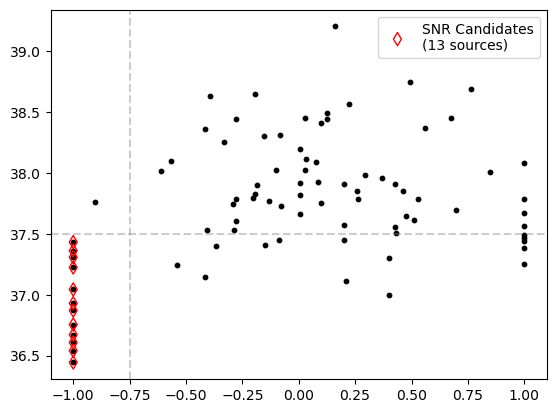

,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,6,8.100148,2CXO J112015.0+125921,170.062538,12.989251,0.417169,0.377474,174.326803,3.028571,TRUE,...,21.057952,0.198328,0.467468,3722.5237,5527.1337,11.798781,CXO007,In,37.043263,1
1,8,8.748180,2CXO J112014.7+125937,170.061339,12.993597,0.373752,0.353781,175.324238,4.062500,TRUE,...,24.189117,0.198165,0.465134,3828.6427,5922.0231,11.739872,CXO009,In,37.307865,1
2,24,45.142910,2CXO J112015.7+125845,170.065490,12.979281,0.496865,0.398594,114.179479,2.473684,MARGINAL,...,15.428362,0.230993,0.557056,3461.1296,4621.2181,14.059974,CXO025,In,36.755654,1
3,32,55.540360,2CXO J112018.8+125932,170.078417,12.992199,0.355246,0.352550,100.025275,4.722222,TRUE,...,39.647935,0.180155,0.412782,2316.6505,5795.1184,10.418516,CXO033,In,37.432311,1
4,34,56.010743,2CXO J112018.8+125924,170.078512,12.990211,0.382236,0.374887,10.207139,3.696970,TRUE,...,27.972545,0.204380,0.478708,2308.1864,5614.4769,12.082486,CXO035,In,37.223740,1
5,41,62.781313,2CXO J112019.1+125947,170.079790,12.996356,0.568604,0.431156,177.945615,2.270270,TRUE,...,10.844639,0.327688,0.814304,2195.1306,6172.7859,20.552848,CXO042,In,36.671921,1
6,43,64.596761,2CXO J112016.7+125830,170.069903,12.975028,0.432959,0.416387,110.602463,2.914286,TRUE,...,18.872017,0.226934,0.542665,3070.3973,4234.8121,13.696748,CXO044,In,36.870636,1
7,44,68.719164,2CXO J112016.4+130034,170.068581,13.009677,0.898680,0.567040,149.540655,1.846154,TRUE,...,7.793080,0.424152,1.077406,3187.5345,7383.1631,27.193498,CXO045,In,-inf,1
8,46,72.223544,2CXO J112019.5+125958,170.081516,12.999423,0.611480,0.514987,16.123950,2.545455,TRUE,...,11.651285,0.335104,0.832043,2042.3195,6451.4525,21.000582,CXO047,In,36.443881,1
9,47,75.034310,2CXO J112014.8+125814,170.061855,12.970670,0.374988,0.359765,24.192297,4.315789,TRUE,...,33.960968,0.182755,0.421194,3782.9501,3838.8041,10.630845,CXO048,In,37.361746,1


In [49]:
M66_best['LogLx'] = np.log10(Lum(F=M66_best['Flux'], dist=1.01e+7)) # 10.1 Mpc as used by PHANGS (https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for their analysis
M66_best = FindSNRs(M66_best)
display(Find(M66_best, "(SNR) != 0"))
M66_best.to_csv(chandra_hst_dir+'M66_csc_bestrads.frame')

# Estimating XRB Masses with CMDs and CCDs

## Extracting photometry with `GetDaoPhots`

In [58]:
DaoCleanMatch

,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,StarID
0,3728.392237,5731.691614,18393,NaN,95500.0,34799.0,17413.0,170.062466,12.991505,2CXO J112014.9+125929,1
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413.0,170.062444,12.991539,2CXO J112014.9+125929,2
2,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,170.062890,12.991310,2CXO J112015.0+125928,1
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928,2
4,3746.714500,5828.653600,19206,NaN,NaN,35989.0,NaN,170.062260,12.992573,2CXO J112014.9+125933,1
...,...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812.0,157738.0,59483.0,NaN,170.062011,13.020465,2CXO J112014.9+130113,1
258,4463.710840,2888.783967,1804,48203.0,NaN,NaN,1718.0,170.054162,12.960218,2CXO J112013.0+125736,1
259,3375.849092,2661.999469,1476,NaN,25603.0,5443.0,1413.0,170.066447,12.957722,2CXO J112015.9+125727,1
260,3375.849092,2661.999469,1476,NaN,25753.0,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727,2


In [61]:
DaoCleanMatch = LoadSources(hstdir+'M66_daoclean_matches.frame')

dist = 1.01e+7 # units pc from https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table
dmod = 5 * np.log10(dist) - 5
cd(hstdir)
DaoCleanPhots = GetDaoPhots(DaoCleanMatch, 
                            photfiles=['photometry_M66_f555w_wfc3_sources.ecsv',
                                       'photometry_M66_f438w_wfc3_sources.ecsv',
                                       'photometry_M66_f814w_wfc3_sources.ecsv',
                                       'photometry_M66_f275w_wfc3_sources.ecsv',
                                       'photometry_M66_f336w_wfc3_sources.ecsv'],
                            idheads=['F555W ID', 'F438W ID', 'F814W ID', 'F275W ID', 'F336W ID'],
                            filters=['F555W', 'F438W', 'F814W', 'F275W', 'F336W'],
                            magheader='aperture_mag_corr', dmod=dmod)
DaoCleanPhots['ID'] = DaoCleanMatch['StarID']
display(DaoCleanPhots)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daoclean_matches.frame...
Searching photometry_M66_f555w_wfc3_sources.ecsv
Searching photometry_M66_f438w_wfc3_sources.ecsv
Searching photometry_M66_f814w_wfc3_sources.ecsv
Searching photometry_M66_f275w_wfc3_sources.ecsv
Searching photometry_M66_f336w_wfc3_sources.ecsv


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,...,F555W Err,F438W,F438W Err,F814W,F814W Err,F275W,F275W Err,F336W,F336W Err,ID
0,3728.392237,5731.691614,18393,NaN,95500.0,34799.0,17413.0,170.062466,12.991505,2CXO J112014.9+125929,...,-0.044221,-11.206933,-0.038940,-13.410549,-0.046098,NaN,NaN,-10.554042,-0.046133,1
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413.0,170.062444,12.991539,2CXO J112014.9+125929,...,-0.053822,NaN,NaN,-13.410549,-0.046098,NaN,NaN,NaN,NaN,2
2,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,170.062890,12.991310,2CXO J112015.0+125928,...,-0.226729,-9.220154,-0.221970,NaN,NaN,NaN,NaN,-8.344256,-0.309419,1
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928,...,-0.251969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,3746.714500,5828.653600,19206,NaN,NaN,35989.0,NaN,170.062260,12.992573,2CXO J112014.9+125933,...,-0.916613,-7.598539,-0.811469,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812.0,157738.0,59483.0,NaN,170.062011,13.020465,2CXO J112014.9+130113,...,-0.161998,-5.115863,-0.148391,NaN,NaN,-4.189977,-0.252669,-5.613635,-0.073280,1
258,4463.710840,2888.783967,1804,48203.0,NaN,NaN,1718.0,170.054162,12.960218,2CXO J112013.0+125736,...,-0.496001,NaN,NaN,-6.093560,-0.407560,-5.281671,-0.067507,NaN,NaN,1
259,3375.849092,2661.999469,1476,NaN,25603.0,5443.0,1413.0,170.066447,12.957722,2CXO J112015.9+125727,...,-0.055671,-6.398322,-0.042113,-6.038592,-0.206731,NaN,NaN,-6.705100,-0.063543,1
260,3375.849092,2661.999469,1476,NaN,25753.0,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727,...,-0.055671,NaN,NaN,NaN,NaN,NaN,NaN,-7.841630,-0.024830,2


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F814W - F555W', ylabel='F275W'>)

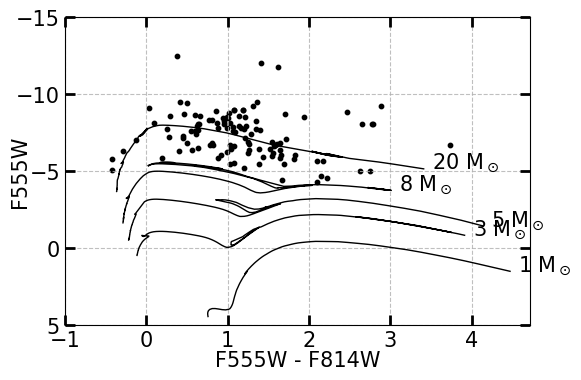

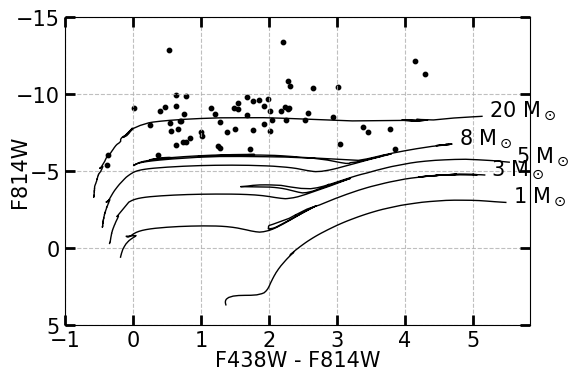

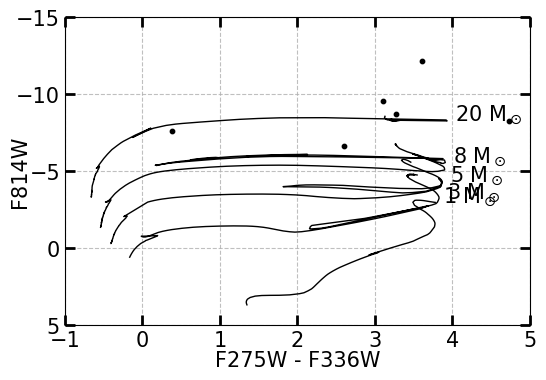

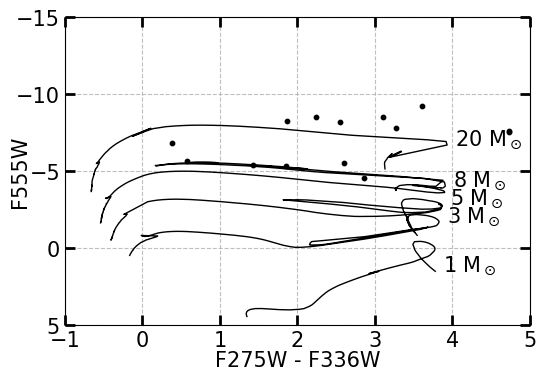

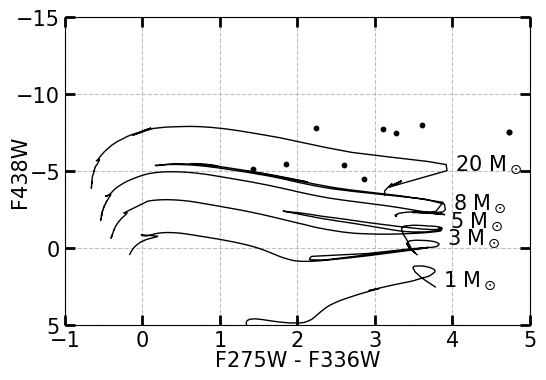

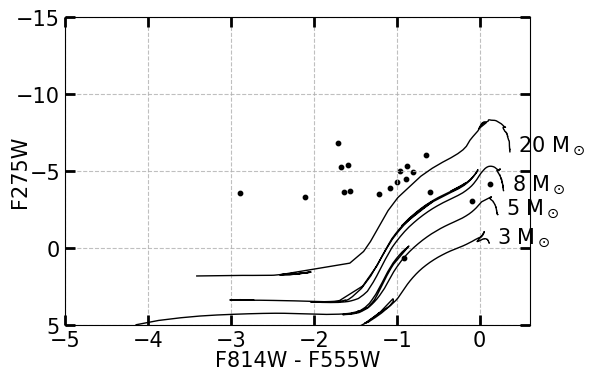

In [66]:
MakeCMD(DaoCleanPhots, xcolor=["F555W", "F814W"], ycolor="F555W", 
        instrument="WFC3", ylim=(5,-15), xlim=-1, save=True,
        savefile='/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/f555w-f814w.png')

MakeCMD(DaoCleanPhots, xcolor=["F438W", "F814W"], ycolor="F814W", 
        instrument="WFC3", ylim=(5,-15), xlim=-1, save=True,
        savefile='/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/f438w-f814w.png')

MakeCMD(DaoCleanPhots, xcolor=['F275W', 'F336W'], ycolor="F814W", 
        instrument="WFC3", ylim=(5,-15), xlim=-1)

MakeCMD(DaoCleanPhots, xcolor=['F275W', 'F336W'], ycolor="F555W", 
        instrument="WFC3", ylim=(5,-15), xlim=-1)

MakeCMD(DaoCleanPhots, xcolor=['F275W', 'F336W'], ycolor="F438W", 
        instrument="WFC3", ylim=(5,-15), xlim=-1)

MakeCMD(DaoCleanPhots, xcolor=['F814W', 'F555W'], ycolor="F275W", 
        instrument="WFC3", ylim=(5,-15), xlim=-5)

## Aging clusters on a CCD

In [67]:
# Clusters found by crossreferencing with the phangs cluster catalog
clusters = ['2CXO J112016.8+125959', 
            '2CXO J112017.6+125856',
            '2CXO J112018.3+125900',
            '2CXO J112013.4+130026']

for cluster in clusters:
    display(Find(M66_best, f'CSC ID = {cluster}'))

,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,23,40.019445,2CXO J112016.8+125959,170.070149,12.999835,0.373094,0.35607,147.178723,3.69697,TRUE,...,25.199068,0.213056,0.502163,3048.736,6488.8994,12.674487,CXO024,In,37.785877,0


,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,28,50.286214,2CXO J112017.6+125856,170.073389,12.982303,0.510491,0.488263,10.047751,2.833333,TRUE,...,17.754434,0.230645,0.553381,2761.7615,4895.8277,13.967203,CXO029,In,37.608163,0


,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,33,55.97942,2CXO J112018.3+125900,170.076294,12.983515,0.295414,0.294581,3.00966,25.684046,TRUE,...,964.821287,0.108451,0.221103,2504.5935,5006.0404,5.580597,CXO034,In,39.202301,0


,Unnamed: 0,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,39,61.281696,2CXO J112013.4+130026,170.05588,13.007213,0.321051,0.312265,146.462704,8.347813,TRUE,...,108.657318,0.139706,0.302824,4311.9565,7159.2523,7.64322,CXO040,In,38.095207,0


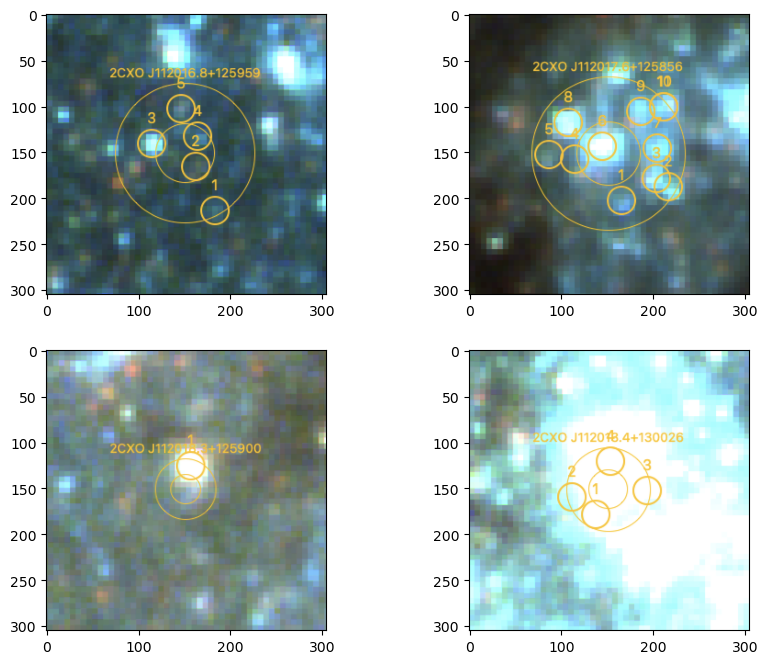

In [109]:
# Let's image the clusters here real quick
clusters_id = ['CXO024', 'CXO029', 'CXO034', 'CXO040']
cd(chandra_hst_dir+'XRB_images')
cluster_images = [f'M66_XRB_candidates_{clusters_id[i]}.png' for i in range(len(clusters_id))]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax[0, 0].imshow(mpimg.imread(cluster_images[0]))
ax[0, 1].imshow(mpimg.imread(cluster_images[1]))
ax[1, 0].imshow(mpimg.imread(cluster_images[2]))
ax[1, 1].imshow(mpimg.imread(cluster_images[3]))
plt.show()

In [154]:
starid =  [8, 1, 2] # Not taking any of the sources from the 1st cluster since they are all the point sources

Clusters = BuildFrame(headers=DaoCleanMatch.columns.tolist())
clusters = [# '2CXO J112016.8+125959', 
            '2CXO J112017.6+125856',
            '2CXO J112018.3+125900',
            '2CXO J112013.4+130026']

for i in range(len(clusters)): 
    Temp = Find(DaoCleanMatch, ["CSC ID = " + clusters[i]]).loc[[starid[i]-1]]
    Clusters = pd.concat([Clusters, pd.DataFrame(Temp)])
Clusters = Clusters.reset_index().drop(columns='index')
display(Clusters)

ClustersPhots = GetDaoPhots(Clusters, 
                            photfiles=["photometry_M66_f555w_wfc3_extended.ecsv",
                                       "photometry_M66_f438w_wfc3_extended.ecsv",
                                       "photometry_M66_f814w_wfc3_extended.ecsv",
                                       "photometry_M66_f336w_wfc3_extended.ecsv",
                                       "photometry_M66_f275w_wfc3_extended.ecsv"],  
                            idheads=["F555W ID", "F438W ID", "F814W ID", "F336W ID", "F275W ID"], 
                            filters=["F555W", "F438W", "F814W", "F336W", "F275W"], 
                            magheader="aperture_mag_corr", dmod=dmod)

display(ClustersPhots)

,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,StarID
0,2754.588454,4901.407635,11610,NaN,77565.0,24735.0,10847.0,170.073465,12.982367,2CXO J112017.6+125856,8
1,2505.543551,5010.300555,12590,NaN,79727.0,26196.0,11697.0,170.076278,12.983566,2CXO J112018.3+125900,1
2,4305.368668,7157.762918,30918,174628.0,NaN,53326.0,29698.0,170.055949,13.007200,2CXO J112013.4+130026,2


Searching photometry_M66_f555w_wfc3_extended.ecsv
Searching photometry_M66_f438w_wfc3_extended.ecsv
Searching photometry_M66_f814w_wfc3_extended.ecsv
Searching photometry_M66_f336w_wfc3_extended.ecsv
Searching photometry_M66_f275w_wfc3_extended.ecsv


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,...,F555W,F555W Err,F438W,F438W Err,F814W,F814W Err,F336W,F336W Err,F275W,F275W Err
0,2754.588454,4901.407635,11610,NaN,77565.0,24735.0,10847.0,170.073465,12.982367,2CXO J112017.6+125856,...,-9.028842,-0.035647,-9.003485,-0.022771,-9.775655,-0.059462,-9.816005,-0.013949,NaN,NaN
1,2505.543551,5010.300555,12590,NaN,79727.0,26196.0,11697.0,170.076278,12.983566,2CXO J112018.3+125900,...,-7.702000,-0.099039,-7.131956,-0.118778,-8.909294,-0.092875,-6.389717,-0.299929,NaN,NaN
2,4305.368668,7157.762918,30918,174628.0,NaN,53326.0,29698.0,170.055949,13.007200,2CXO J112013.4+130026,...,-10.861056,-0.018933,-9.318461,-0.054887,-10.350403,-0.078865,NaN,NaN,-4.747589,-0.186419


Plotting without extinction
Plotting reddening arrow for V-I vs. B-V
Plotting with extinction
Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

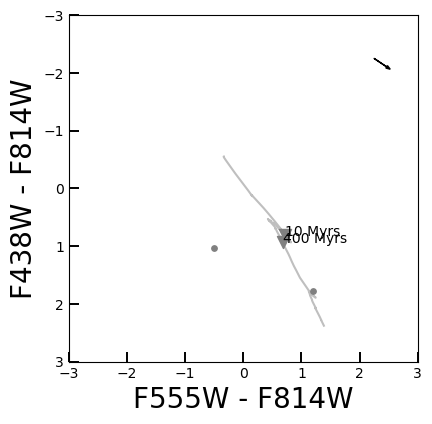

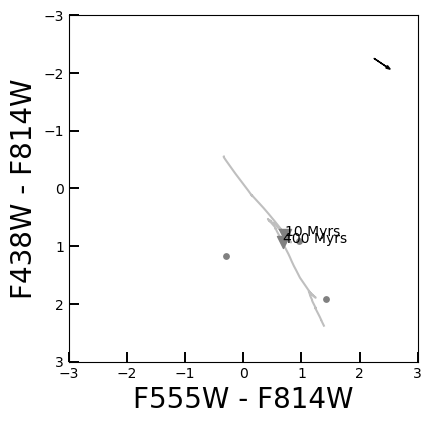

In [158]:
print("Plotting without extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=False, ycolor=['F438W', 'F814W'], instrument='wfc3')
print("Plotting with extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=True, ycolor=['F438W', 'F814W'], instrument='wfc3')

Plotting without extinction
Plotting reddening arrow for V-I vs. B-V
Plotting with extinction
Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

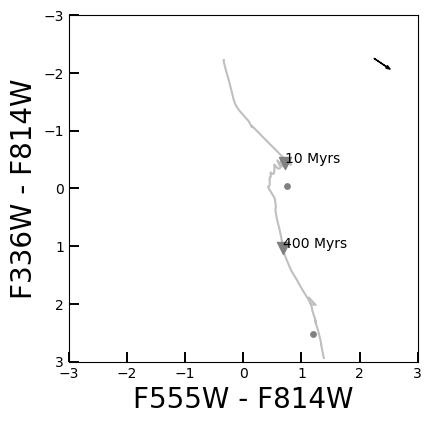

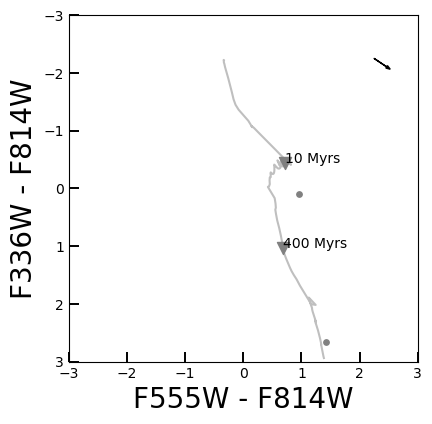

In [159]:
print("Plotting without extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=False, ycolor=['F336W', 'F814W'], instrument='wfc3')
print("Plotting with extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=True, ycolor=['F336W', 'F814W'], instrument='wfc3')

Plotting without extinction
Plotting reddening arrow for V-I vs. B-V
Plotting with extinction
Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

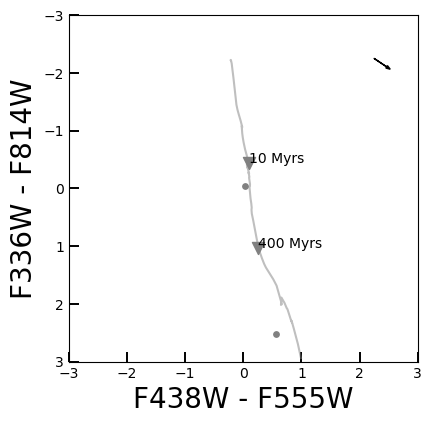

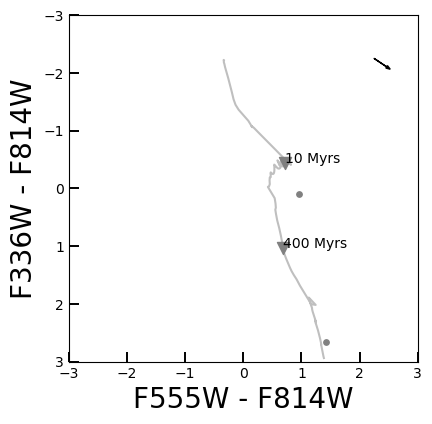

In [160]:
print("Plotting without extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=False, xcolor=['F438W', 'F555W'], ycolor=['F336W', 'F814W'], instrument='wfc3')
print("Plotting with extinction")
MakeCCD(ClustersPhots, color='gray', E_BV=0.146, correct_ext=True, ycolor=['F336W', 'F814W'], instrument='wfc3')

## Mass Estimation with Spectral Energy Distribution

In [11]:
DaoCleanMatch = LoadSources(chandra_hst_dir+'M66_daoclean_matches.frame')
display(DaoCleanMatch)

dist = 1.01e+7 # units pc from https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table
dmod = 5 * np.log10(dist) - 5
cd(hstdir)
DaoCleanPhots = GetDaoPhots(DaoCleanMatch, 
                            photfiles=['photometry_M66_f555w_wfc3_sources.ecsv',
                                       'photometry_M66_f438w_wfc3_sources.ecsv',
                                       'photometry_M66_f814w_wfc3_sources.ecsv',
                                       'photometry_M66_f275w_wfc3_sources.ecsv',
                                       'photometry_M66_f336w_wfc3_sources.ecsv'],
                            idheads=['F555W ID', 'F438W ID', 'F814W ID', 'F275W ID', 'F336W ID'],
                            filters=['F555W', 'F438W', 'F814W', 'F275W', 'F336W'],
                            magheader='aperture_mag_corr', dmod=dmod)

DaoCleanPhots['ID'] = DaoCleanMatch['StarID']
display(DaoCleanPhots)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_daoclean_matches.frame...


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,StarID
0,3728.392237,5731.691614,18393,NaN,95500.0,34799.0,17413.0,170.062466,12.991505,2CXO J112014.9+125929,1
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413.0,170.062444,12.991539,2CXO J112014.9+125929,2
2,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,170.062890,12.991310,2CXO J112015.0+125928,1
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928,2
4,3746.714500,5828.653600,19206,NaN,NaN,35989.0,NaN,170.062260,12.992573,2CXO J112014.9+125933,1
...,...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812.0,157738.0,59483.0,NaN,170.062011,13.020465,2CXO J112014.9+130113,1
258,4463.710840,2888.783967,1804,48203.0,NaN,NaN,1718.0,170.054162,12.960218,2CXO J112013.0+125736,1
259,3375.849092,2661.999469,1476,NaN,25603.0,5443.0,1413.0,170.066447,12.957722,2CXO J112015.9+125727,1
260,3375.849092,2661.999469,1476,NaN,25753.0,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727,2


Searching photometry_M66_f555w_wfc3_sources.ecsv
Searching photometry_M66_f438w_wfc3_sources.ecsv
Searching photometry_M66_f814w_wfc3_sources.ecsv
Searching photometry_M66_f275w_wfc3_sources.ecsv
Searching photometry_M66_f336w_wfc3_sources.ecsv


,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,RA,Dec,CSC ID,...,F555W Err,F438W,F438W Err,F814W,F814W Err,F275W,F275W Err,F336W,F336W Err,ID
0,3728.392237,5731.691614,18393,NaN,95500.0,34799.0,17413.0,170.062466,12.991505,2CXO J112014.9+125929,...,-0.044221,-11.206933,-0.038940,-13.410549,-0.046098,NaN,NaN,-10.554042,-0.046133,1
1,3730.382900,5734.693669,18431,NaN,NaN,NaN,17413.0,170.062444,12.991539,2CXO J112014.9+125929,...,-0.053822,NaN,NaN,-13.410549,-0.046098,NaN,NaN,NaN,NaN,2
2,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,170.062890,12.991310,2CXO J112015.0+125928,...,-0.226729,-9.220154,-0.221970,NaN,NaN,NaN,NaN,-8.344256,-0.309419,1
3,3693.339708,5721.089782,18303,NaN,NaN,NaN,NaN,170.062862,12.991389,2CXO J112015.0+125928,...,-0.251969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,3746.714500,5828.653600,19206,NaN,NaN,35989.0,NaN,170.062260,12.992573,2CXO J112014.9+125933,...,-0.916613,-7.598539,-0.811469,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,3768.771693,8363.063045,34886,203812.0,157738.0,59483.0,NaN,170.062011,13.020465,2CXO J112014.9+130113,...,-0.161998,-5.115863,-0.148391,NaN,NaN,-4.189977,-0.252669,-5.613635,-0.073280,1
258,4463.710840,2888.783967,1804,48203.0,NaN,NaN,1718.0,170.054162,12.960218,2CXO J112013.0+125736,...,-0.496001,NaN,NaN,-6.093560,-0.407560,-5.281671,-0.067507,NaN,NaN,1
259,3375.849092,2661.999469,1476,NaN,25603.0,5443.0,1413.0,170.066447,12.957722,2CXO J112015.9+125727,...,-0.055671,-6.398322,-0.042113,-6.038592,-0.206731,NaN,NaN,-6.705100,-0.063543,1
260,3375.849092,2661.999469,1476,NaN,25753.0,NaN,NaN,170.066447,12.957722,2CXO J112015.9+125727,...,-0.055671,NaN,NaN,NaN,NaN,NaN,NaN,-7.841630,-0.024830,2


In [56]:
M66_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt").drop("Unnamed: 0", axis=1)
display(M66_notes)

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,0,2CXO J112014.9+125929,CXO001,Nucleus,2.0,NaN,NaN
1,1,2CXO J112015.0+125928,CXO002,Nucleus,1.0,NaN,According to the cassoc catalog this is a comp...
2,2,2CXO J112014.9+125933,CXO003,Nucleus,2.0,NaN,NaN
3,4,2CXO J112015.3+125932,CXO005,Nucleus,NaN,NaN,Optical Counterpart not observed with HST
4,5,2CXO J112015.0+125936,CXO006,Nucleus,1.0,NaN,NaN
5,6,2CXO J112015.0+125921,CXO007,Nucleus,1.0,NaN,NaN
6,7,2CXO J112015.2+125921,CXO008,Nucleus,2.0,NaN,NaN
7,8,2CXO J112014.7+125937,CXO009,Nucleus,1.0,NaN,NaN
8,9,2CXO J112015.0+125938,CXO010,Nucleus,1.0,NaN,NaN
9,10,2CXO J112014.2+125927,CXO011,Nucleus,NaN,NaN,Optical Counterpart not observed with HST


### HMXBs

In [57]:
hmxbs = Find(M66_notes, 'Class = HMXB')
display(hmxbs)
len(hmxbs)

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,18,2CXO J112013.5+125944,CXO019,HMXB,1.0,NaN,NaN
1,21,2CXO J112012.8+125947,CXO022,HMXB,1.0,NaN,NaN
2,23,2CXO J112016.8+125959,CXO024,HMXB,3.0,NaN,A cluster is very nearby
3,34,2CXO J112018.8+125924,CXO035,HMXB,2.0,NaN,Very close to a stellar association and also a gc
4,35,2CXO J112013.7+130025,CXO036,HMXB,4.0,NaN,NaN
5,43,2CXO J112016.7+125830,CXO044,HMXB,1.0,NaN,NaN
6,46,2CXO J112019.5+125958,CXO047,HMXB,1.0,NaN,(1) Very near a globular cluster (2) Maybe ej...
7,50,2CXO J112019.0+130027,CXO051,HMXB,3.0,NaN,A very bright source not identified by my code
8,51,2CXO J112011.8+125811,CXO052,HMXB,1.0,NaN,NaN
9,55,2CXO J112014.9+130113,CXO057,HMXB,1.0,NaN,NaN


12

### LMXBs
Note that these LMXBs are determined visually. These are the sources where I did not detect an optical counterpart to the X-ray source.

In [58]:
lmxbs = Find(M66_notes, 'Class = LMXB')
display(lmxbs)
len(lmxbs)

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,16,2CXO J112013.9+125913,CXO017,LMXB,NaN,NaN,Optical Counterpart not observed with HST
1,17,2CXO J112013.4+125928,CXO018,LMXB,NaN,NaN,Optical Counterpart not observed with HST
2,19,2CXO J112015.5+125955,CXO020,LMXB,NaN,NaN,Optical Counterpart not observed with HST
3,22,2CXO J112012.6+125947,CXO023,LMXB,NaN,NaN,Optical Counterpart not observed with HST
4,25,2CXO J112017.1+130003,CXO026,LMXB,NaN,NaN,Optical counterpart not observed with HST
5,26,2CXO J112012.2+125952,CXO027,LMXB,NaN,NaN,Optical counterpart not observed with HST
6,27,2CXO J112012.0+125910,CXO028,LMXB,NaN,NaN,Optical counterpart not observed with HST
7,29,2CXO J112015.8+130019,CXO030,LMXB,NaN,NaN,Optical counterpart not observed with HST
8,30,2CXO J112016.6+125844,CXO031,LMXB,NaN,NaN,Optical counterpart not observed with HST
9,31,2CXO J112018.2+125959,CXO032,LMXB,NaN,NaN,Optical counterpart not observed with HST


22

## Clusters

In [59]:
clusters = Find(M66_notes, 'Class = Cluster')
display(clusters)
len(clusters)

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,28,2CXO J112017.6+125856,CXO029,Cluster,6.0,NaN,Very clearly a cluster but are you a globular ...
1,39,2CXO J112013.4+130026,CXO040,Cluster,1.0,NaN,Not sure what kind of a cluster


2

### Globular Clusters

In [52]:
globularclusters = Find(M66_notes, 'Class = Globular Cluster')
display(globularclusters)
len(globularclusters)

,Unnamed: 0,CSC ID,ID,Class,Best Star,Mass,Notes
0,33,2CXO J112018.3+125900,CXO034,Globular Cluster,1.0,NaN,Finally a beautiful globully-globular cluster


1

### Compact Associations

In [60]:
comp_assoc = Find(M66_notes, 'Class = Compact Association')
display(comp_assoc)
len(comp_assoc)

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,24,2CXO J112015.7+125845,CXO025,Compact Association,1.0,NaN,(1) Would that be an HMXB then?
1,32,2CXO J112018.8+125932,CXO033,Compact Association,2.0,NaN,Are you an HMXB or LMXB?
2,41,2CXO J112019.1+125947,CXO042,Compact Association,4.0,NaN,(1) 5 and 6 are also good sources
3,45,2CXO J112013.2+130035,CXO046,Compact Association,8.0,NaN,(1) 2 is also a good candidate (2) 8 seems a l...


4

## Questions

1. What kind of clusters are the ones below?
In the first image, I identified the source 6 as the cluster because it was very cluster looking. Would there be a HMXB in that cluster? 
CHECK MASS OF THIS CLUSTER.

In the second image, I identified source 4 as the 'best star' after playing around with the scale parameters of the galaxy some more

#### 2CXO J112017.6+125856
1. Classification: What kind of a cluster? 

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,28,2CXO J112017.6+125856,CXO029,Cluster,6.0,NaN,Very clearly a cluster but are you a globular ...


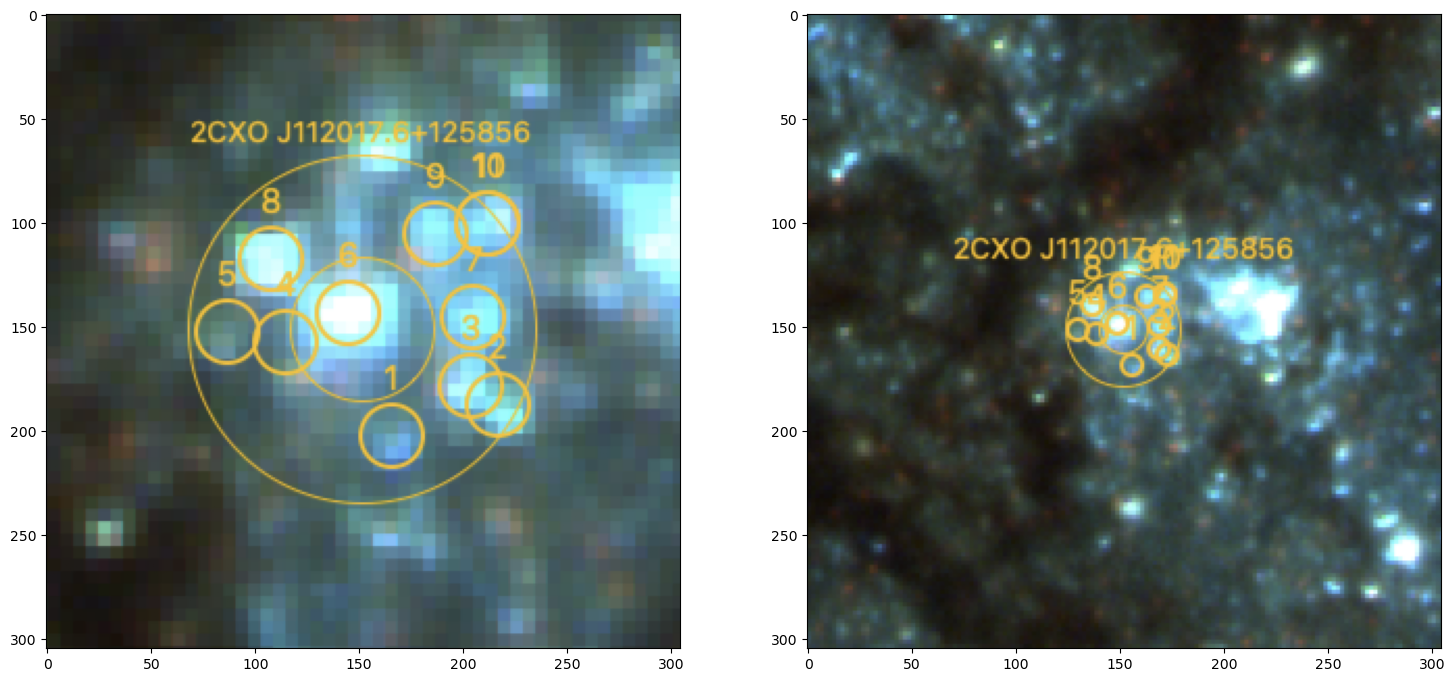

In [114]:
interesting_clusters = clusters['ID'].tolist()
cd(chandra_hst_dir+'XRB_images')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 15))
ax[0].imshow(mpimg.imread('M66_XRB_candidates_CXO029.png'))
ax[1].imshow(mpimg.imread('M66_XRB_candidates_CXO029_env.png'))

Find(M66_notes, 'CSC ID = 2CXO J112017.6+125856')

#### 2CXO J12018.4+130026
- classifcation?

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,39,2CXO J112013.4+130026,CXO040,Cluster,1.0,NaN,Not sure what kind of a cluster


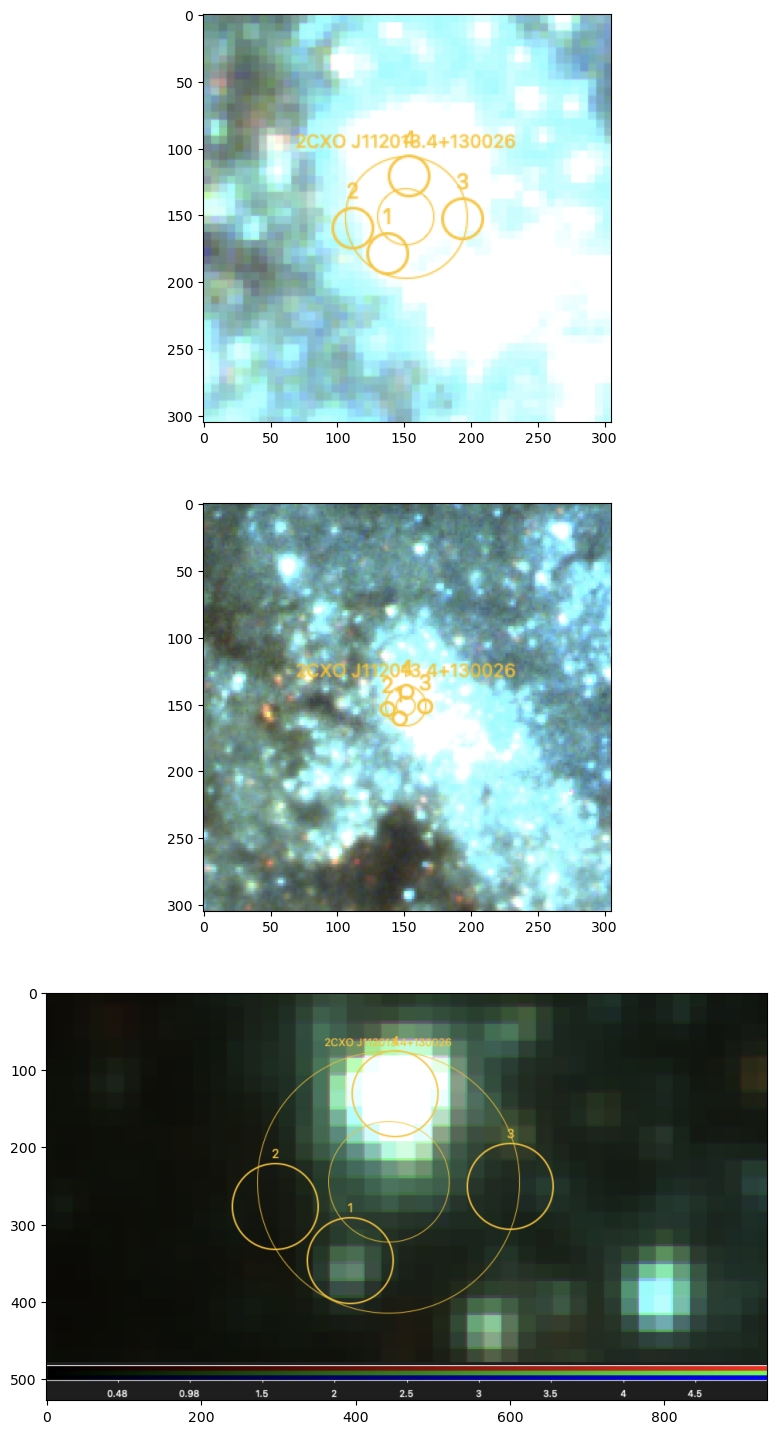

In [117]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))
ax[0].imshow(mpimg.imread('M66_XRB_candidates_CXO040.png'))
ax[1].imshow(mpimg.imread('M66_XRB_candidates_CXO040_env.png'))
ax[2].imshow(mpimg.imread('/Users/undergradstudent/Downloads/interesting_cluster.png'))
Find(M66_notes, 'CSC ID = 2CXO J112013.4+130026')

#### 2CXO J112016.8+125959
 What will be its classification? HMXB in the 2sig? Cluster? <br>
**Is the XRB ejected from the cluster?**

In [95]:
Find(M66_notes, 'CSC ID = 2CXO J112016.8+125959')

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,23,2CXO J112016.8+125959,CXO024,HMXB,3.0,NaN,A cluster is very nearby


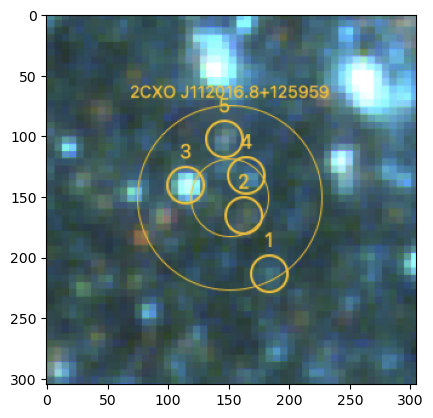

In [ ]:
plt.imshow(mpimg.imread('M66_XRB_candidates_CXO024.png'))


#### 2CXO J112015.7+125845

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,24,2CXO J112015.7+125845,CXO025,Compact Association,1.0,NaN,(1) Would that be an HMXB then?


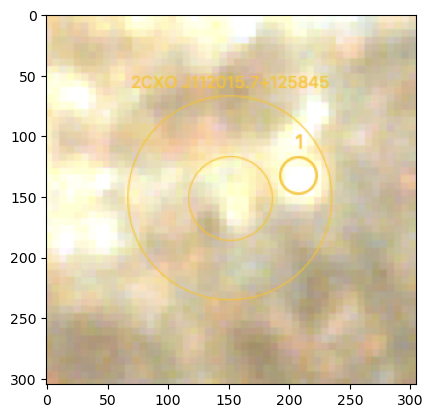

In [122]:
plt.imshow(mpimg.imread('M66_XRB_candidates_CXO025.png'))
Find(M66_notes, 'CSC ID = 2CXO J112015.7+125845')

#### 2CXO J112018.8+125932

,Unnamed: 0.1,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,32,55.54036,2CXO J112018.8+125932,170.078417,12.992199,0.355246,0.35255,100.025275,4.722222,TRUE,...,39.647935,0.180155,0.412782,2316.6505,5795.1184,10.418516,CXO033,In,37.432311,1


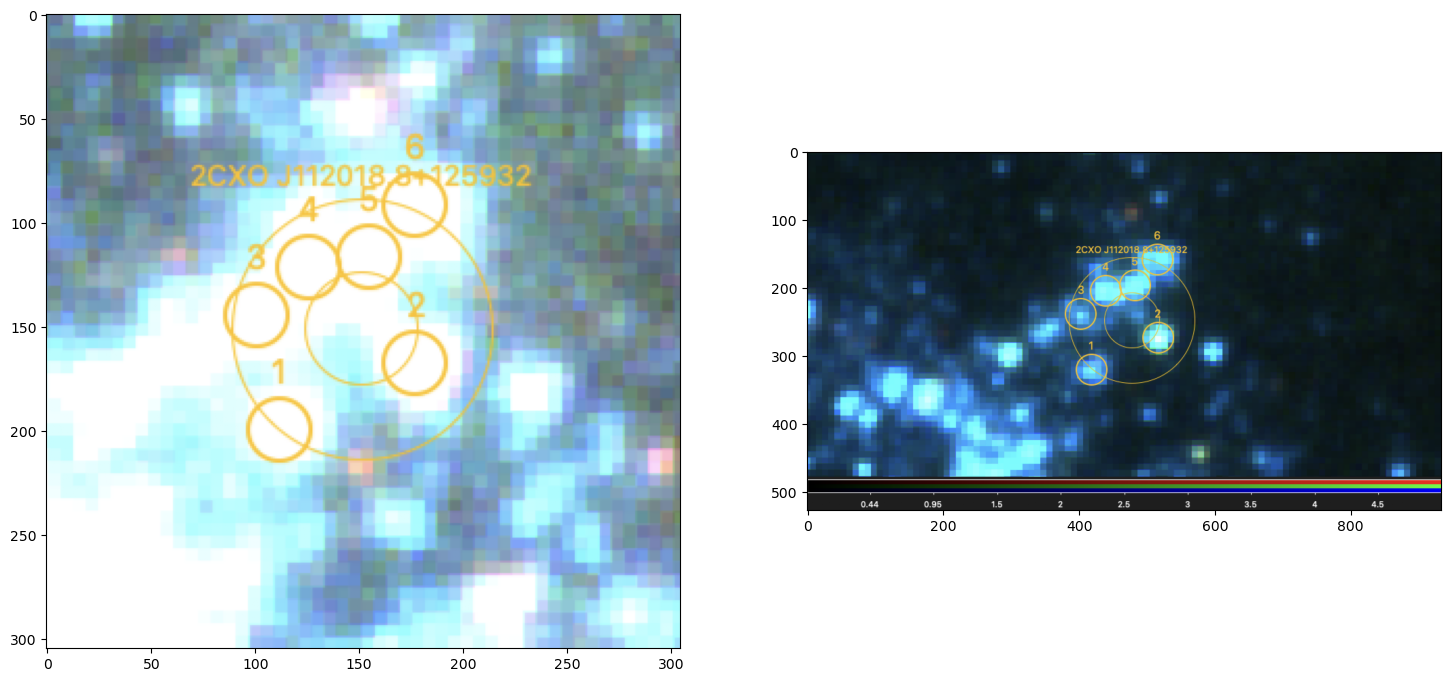

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 15))

ax[0].imshow(mpimg.imread('M66_XRB_candidates_CXO033.png'))
ax[1].imshow(mpimg.imread('/Users/undergradstudent/Downloads/beautiful_compact_association.png'))
Find(M66_best, 'CSC ID = 2CXO J112018.8+125932')

#### 2CXO J112019.5+125958
What should be the appropriate classification for this source? Is the xrb ejected from the cluster? 

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,46,2CXO J112019.5+125958,CXO047,HMXB,1.0,NaN,(1) Very near a globular cluster (2) Maybe ej...


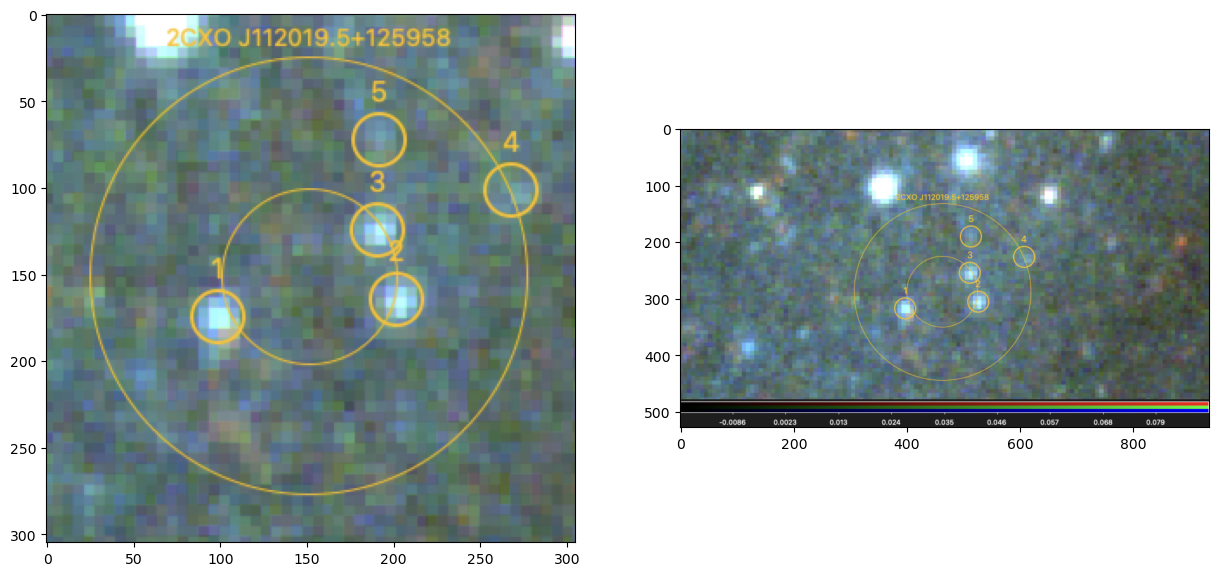

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
ax[0].imshow(mpimg.imread('M66_XRB_candidates_CXO047.png'))
ax[1].imshow(mpimg.imread('/Users/undergradstudent/Downloads/another_cluster.png'))
Find(M66_notes, 'CSC ID = 2CXO J112019.5+125958')

In [109]:
Find(M66_best, 'CSC ID = 2CXO J112019.5+125958')

,Unnamed: 0.1,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,...,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID,Bounds,LogLx,(SNR)
0,46,72.223544,2CXO J112019.5+125958,170.081516,12.999423,0.61148,0.514987,16.12395,2.545455,TRUE,...,11.651285,0.335104,0.832043,2042.3195,6451.4525,21.000582,CXO047,In,36.443881,1


#### 2CXO J112018.9+130135
Is it a globular cluster

,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,58,2CXO J112018.9+130135,CXO067,Globular Cluster,1.0,NaN,NaN


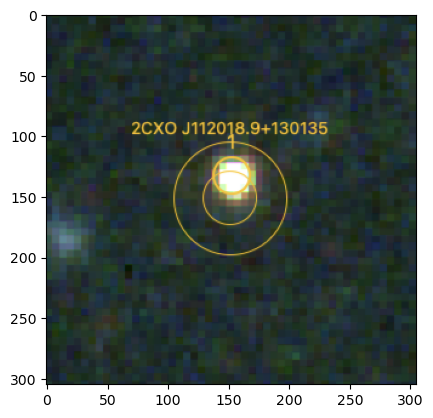

In [128]:
plt.imshow(mpimg.imread('M66_XRB_candidates_CXO067.png'))
Find(M66_notes, 'CSC ID = 2CXO J112018.9+130135')